In [1]:
#Importar librerías
import pandas as pd
import os
import zipfile
import shutil
import requests
import zipfile
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
from shapely.geometry import box
import folium
from branca.element import Template, MacroElement
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import randint

In [2]:
#Definir directorio de trabajo
#Directorio de trabajo. Si existe directorio D:/, se selecciona si no, C:/
try:
    os.chdir('C:/users/claud/Documents/GitHub/proyecto_infotec')
except:
    os.chdir('C:/users/claudio.pacheco/Documents/Github/proyecto_infotec')
#if os.path.exists('D:/'):
#    os.chdir('D:/github/proyecto_infotec')
#else:
#    os.chdir('C:/users/claudio.pacheco/Documents/Github/proyecto_infotec')

In [3]:
#crear directorio de salida
if not os.path.exists('datos'):
    os.makedirs('datos')

In [4]:
def download_and_extract(url, filename, check_file_path, extract_path):
    # Checar si el archivo ya existe
    if os.path.isfile(check_file_path):
        print(f"El archivo {filename} existe, no se descargará.")
    else:
        print(f"El archivo {filename} no existe. Descargando.")
        response = requests.get(url)
        with open(filename, "wb") as code:
            code.write(response.content)
        if zipfile.is_zipfile(filename):
            # extraer zip
            with zipfile.ZipFile(filename, "r") as zip_ref:
                zip_ref.extractall(extract_path)
        
        # Eliminar zip
            os.remove(filename)
        else:
            print("El archivo descargado no es un zip. Proceso terminado.")

In [5]:
#Pegar todos los archivos csv en una sola data frame
df=pd.DataFrame()
for entidad in range(1,33):
    if entidad<10:
        df_temp=pd.read_csv("datos/conjunto_de_datos_ageb_urbana_"+"0"+str(entidad)+"_cpv2020.csv",encoding='utf-8', low_memory=False)
    else:
        df_temp=pd.read_csv("datos/conjunto_de_datos_ageb_urbana_"+str(entidad)+"_cpv2020.csv",encoding='utf-8', low_memory=False)
    df=pd.concat([df,df_temp],axis=0)
    print("Se ha agregado la entidad "+str(entidad)," a la dataframe")

#Imprimir el número de registros con separadores de miles
print("Se concluyó la concatenación. El conjunto de datos cuenta con "+str(df.shape[1])+" columnas y "+str("{:,}".format(df.shape[0]))+" registros")
df.columns=df.columns.str.lower()  

Se ha agregado la entidad 1  a la dataframe
Se ha agregado la entidad 2  a la dataframe
Se ha agregado la entidad 3  a la dataframe
Se ha agregado la entidad 4  a la dataframe
Se ha agregado la entidad 5  a la dataframe
Se ha agregado la entidad 6  a la dataframe
Se ha agregado la entidad 7  a la dataframe
Se ha agregado la entidad 8  a la dataframe
Se ha agregado la entidad 9  a la dataframe
Se ha agregado la entidad 10  a la dataframe
Se ha agregado la entidad 11  a la dataframe
Se ha agregado la entidad 12  a la dataframe
Se ha agregado la entidad 13  a la dataframe
Se ha agregado la entidad 14  a la dataframe
Se ha agregado la entidad 15  a la dataframe
Se ha agregado la entidad 16  a la dataframe
Se ha agregado la entidad 17  a la dataframe
Se ha agregado la entidad 18  a la dataframe
Se ha agregado la entidad 19  a la dataframe
Se ha agregado la entidad 20  a la dataframe
Se ha agregado la entidad 21  a la dataframe
Se ha agregado la entidad 22  a la dataframe
Se ha agregado la e

In [6]:
#Copia de la base original
df_limpia=df.copy()

### Procesamiento de información

In [7]:
#Se filtran por las columnas con datos de vivienda
df_limpia= df_limpia.iloc[:, list(range(8)) + list(range(177, len(df_limpia.columns)))]
print("El conjunto de datos cuenta con "+str(df_limpia.shape[1])+" columnas y "+str("{:,}".format(df_limpia.shape[0]))+" registros")

El conjunto de datos cuenta con 61 columnas y 1,683,504 registros


In [8]:
#Crear clave geoestadística
df_limpia['cvegeo'] = df_limpia['entidad'].astype(str).str.zfill(2) + df_limpia['mun'].astype(str).str.zfill(3) + df_limpia['loc'].astype(str).str.zfill(4) + df_limpia['ageb'].astype(str).str.zfill(4) + df_limpia['mza'].astype(str).str.zfill(3)
columnas = ['cvegeo'] + [col for col in df_limpia.columns if col != 'cvegeo']
df_limpia = df_limpia[columnas]

In [9]:
#Eliminar agregados de entidad. 
df_limpia=df_limpia[df_limpia['mun']!=0]
#Eliminar agregados de municipio. 
df_limpia=df_limpia[df_limpia['loc']!=0]
#Eliminar agregados de localidad.
df_limpia=df_limpia[df_limpia['ageb']!='0000']
#Eliminar agregados de manzana.
df_limpia=df_limpia[df_limpia['mza']!=0]

In [10]:
#transformar variables de la 8 en adelante a numéricas
df_limpia.iloc[:,8:]=df_limpia.iloc[:,8:].apply(pd.to_numeric, errors='coerce')

In [11]:
#Eliminar nans y ceros de la variable de viviendas particulares habitadas
df_limpia=df_limpia[df_limpia['tvivparhab']!=0]
df_limpia=df_limpia[df_limpia['tvivparhab'].notna()]
#Transformar nans a ceros
df_limpia=df_limpia.fillna(0)

In [12]:
#Cálculo de indicadores para aproximar el rezago habitacional
#1. Porcentaje de viviendas particulares habitadas que no disponen de excusado o sanitario
df_limpia['p_viv_snexc']=df_limpia['vph_letr']/df_limpia['tvivparhab']*100
#2. Porcentaje de viviendas particulares habitadas cn pisos de tierra
df_limpia['p_viv_ptierra']=(df_limpia['vph_pisoti'])/df_limpia['tvivparhab']*100
#3. Porcentaje de viviendas particulares habitadas cuyos habitantes se encuentran en hacinamiento
#Se asume que los habitantes que ocupan viviendas con un solo cuarto están en hacinamiento
df_limpia['p_viv_hacina']=df_limpia['vph_1cuart']/df_limpia['tvivparhab']*100
#4. Porcentaje de viviendas particulares habitadas que no disponen de agua entubada de la red pública
df_limpia['p_viv_sagua']=df_limpia['vph_aguafv']/df_limpia['tvivparhab']*100
#5. Porcentaje de viviendas particulares habitadas que no disponen de drenaje
df_limpia["p_viv_drena"]=df_limpia["vph_nodren"]/df_limpia['tvivparhab']*100
df_limpia["p_viv_energia"]=df_limpia["vph_s_elec"]/df_limpia['tvivparhab']*100


In [13]:
df_limpia

,cvegeo,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,...,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,p_viv_snexc,p_viv_ptierra,p_viv_hacina,p_viv_sagua,p_viv_drena,p_viv_energia
4,0100100010017001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,1,82,...,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0100100010017002,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,2,83,...,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0100100010017003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,3,84,...,4.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0100100010017004,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,4,84,...,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0100100010017005,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,5,68,...,0.0,3.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33828,3205800010123007,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,7,8,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33831,3205800010123010,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,10,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33834,3205800010123013,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,13,13,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33838,3205800010123017,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,17,5,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#Agregar variables del entorno
url="https://www.inegi.org.mx/contenidos/programas/ccpv/2020/microdatos/ceu/Censo2020_CEU_eum_csv.zip"
download_and_extract(url, "datos/Censo2020_CEU_eum_csv.zip", "datos/TI_MANZANA_EU_00.csv", "datos")

El archivo datos/Censo2020_CEU_eum_csv.zip existe, no se descargará.


In [15]:
entorno=pd.read_csv('datos/TI_MANZANA_EU_00.csv', encoding='latin-1')
#Columnas en minúsculas
entorno.columns=entorno.columns.str.lower()
#Construir la clave de manzana
entorno['cvegeo']=entorno["ent"].astype(str).str.zfill(2)+entorno["mun"].astype(str).str.zfill(3)+entorno["loc"].astype(str).str.zfill(4)+entorno["ageb"].astype(str).str.zfill(4)+entorno["mza"].astype(str).str.zfill(3)
entorno['vialidad_sinrec']=entorno['s_recu_n']/(entorno['totvial'])*100
#Porcentaje de rasgos en la manzana
entorno['rasgos_mza']=entorno['totrasgo']/(entorno['totlado'])*100
#Dejar solo cvegeo y porcentajes
entorno=entorno[['cvegeo','vialidad_sinrec','rasgos_mza']]
#Sustituir Nan por 0
entorno=entorno.fillna(0)
entorno

,cvegeo,vialidad_sinrec,rasgos_mza
0,0100100010017001,0.0,0.0
1,0100100010017002,0.0,0.0
2,0100100010017003,0.0,0.0
3,0100100010017004,0.0,0.0
4,0100100010017005,0.0,0.0
...,...,...,...
1512862,3205800010123017,62.5,0.0
1512863,3205800010123018,100.0,50.0
1512864,3205800010123019,100.0,25.0
1512865,3205800010123020,100.0,0.0


In [16]:
#Pegar entorno a df_limpia
df_limpia=pd.merge(df_limpia,entorno)
df_limpia

,cvegeo,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,...,vph_sincint,vph_sintic,p_viv_snexc,p_viv_ptierra,p_viv_hacina,p_viv_sagua,p_viv_drena,p_viv_energia,vialidad_sinrec,rasgos_mza
0,0100100010017001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,1,82,...,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0100100010017002,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,2,83,...,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0100100010017003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,3,84,...,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0100100010017004,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,4,84,...,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0100100010017005,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,5,68,...,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224778,3205800010123005,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,5,11,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1224779,3205800010123007,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,7,8,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1224780,3205800010123010,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,10,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0
1224781,3205800010123013,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,13,13,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


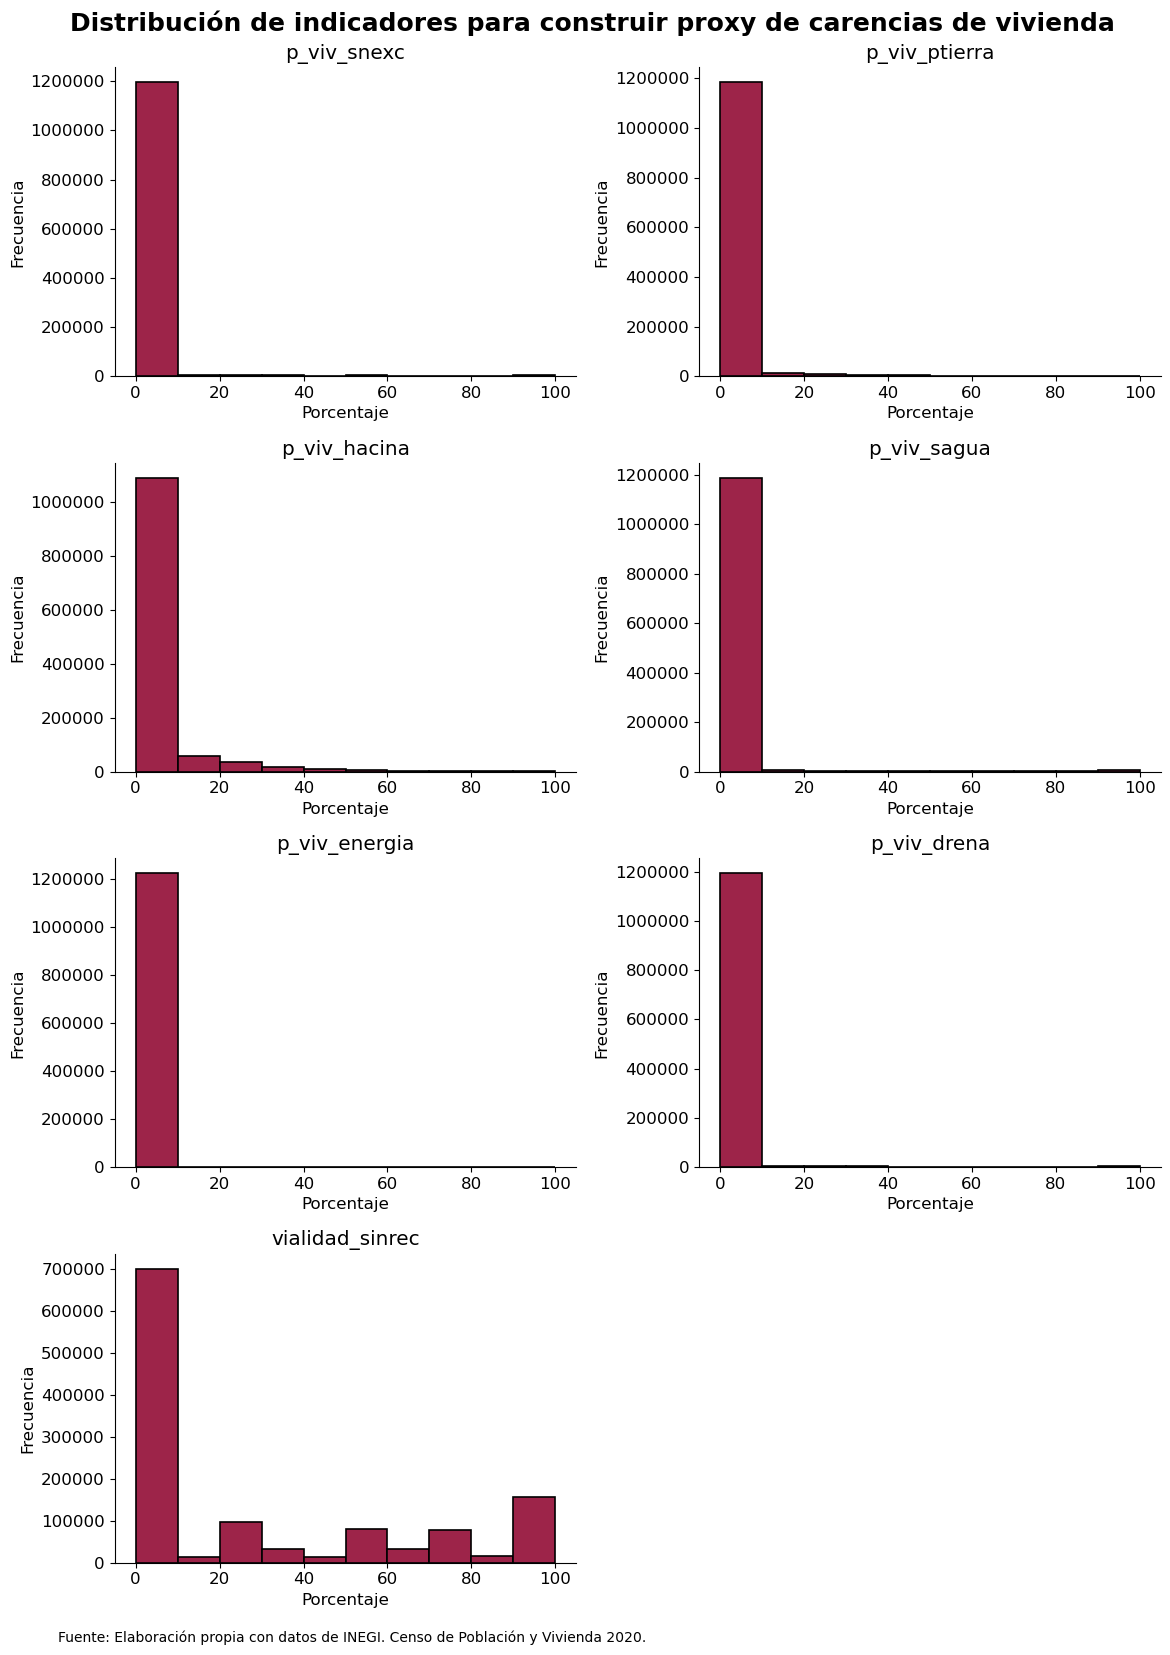

In [17]:
import matplotlib.pyplot as plt

# Configuración del tamaño de la fuente
plt.rcParams.update({'font.size': 12})

# Crear la figura y los ejes para los subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 16)) # Ajusta el tamaño según necesites

# Lista de indicadores
indicadores = ['p_viv_snexc', 'p_viv_ptierra', 'p_viv_hacina', 'p_viv_sagua', 'p_viv_energia', 'p_viv_drena', 'vialidad_sinrec']

# Iterar sobre los indicadores y los ejes
for i, indicador in enumerate(indicadores):
    row = i // 2 # fila del subplot
    col = i % 2  # columna del subplot
    axs[row, col].hist(df_limpia[indicador], bins=10, color='#9d2449', edgecolor='black', linewidth=1.2)
    axs[row, col].set_title(indicador)
    axs[row, col].ticklabel_format(style='plain', axis='y')
    axs[row, col].set_xlabel("Porcentaje")
    axs[row, col].set_ylabel("Frecuencia")
    axs[row, col].spines['right'].set_visible(False)
    axs[row, col].spines['top'].set_visible(False)

# Ajustar el layout para evitar superposición de títulos
plt.tight_layout()
plt.suptitle("Distribución de indicadores para construir proxy de carencias de vivienda", y=1.01, fontsize=18, fontweight='bold')
# Agregar fuente en el pie de página de la figura
plt.figtext(0.3, -0.01, 'Fuente: Elaboración propia con datos de INEGI. Censo de Población y Vivienda 2020.', ha='center', fontsize=10)
#Eliminar el último facet
fig.delaxes(axs[3,1])
# Mostrar la gráf


Text(0.4, -0.4, 'Fuente: Elaboración propia con datos de INEGI. Censo de Población y Vivienda 2020.')

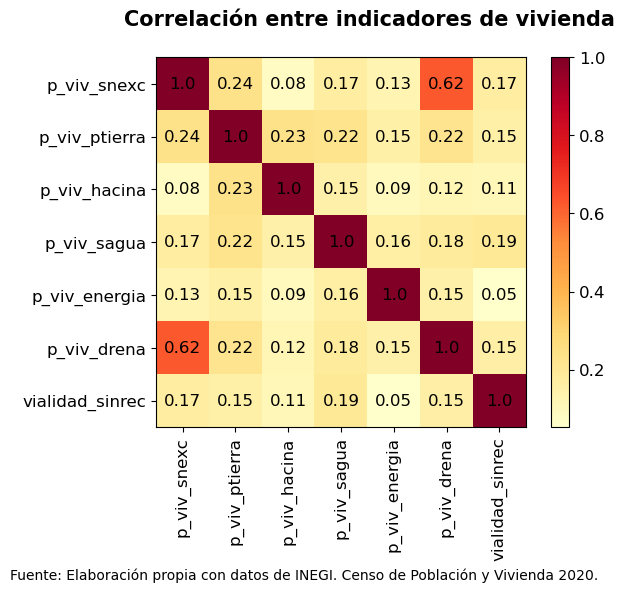

In [18]:
#Crear gráfico con la correlación entre los indicadores
#Crear matriz de correlación
corr=df_limpia[['p_viv_snexc','p_viv_ptierra','p_viv_hacina','p_viv_sagua','p_viv_energia', 'p_viv_drena','vialidad_sinrec']].corr()
#Crear mapa de calor
plt.rcParams.update({'font.size': 12})
plt.imshow(corr, cmap='YlOrRd', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.suptitle('Correlación entre indicadores de vivienda',fontsize=15,fontweight='bold')
#Añadir valores
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, corr.iloc[i, j].round(2), ha="center", va="center",color="black")

#Fuente:
plt.text(0.4, -0.4, 'Fuente: Elaboración propia con datos de INEGI. Censo de Población y Vivienda 2020.', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)

In [19]:
#Suma de viviendas con pisos de tierra, sin excusado y en hacinamiento
print("El número de viviendas con pisos de tierra es "+str("{:,}".format(df_limpia['vph_pisoti'].sum())))
print("El número de viviendas sin excusado es "+str("{:,}".format(df_limpia['vph_letr'].sum())))
print("El número de viviendas en hacinamiento es "+str("{:,}".format(df_limpia['vph_1cuart'].sum()+df_limpia['vph_2cuart'].sum())))
#Total de viviendas particulares habitadas
print("El número de viviendas particulares habitadas es "+str("{:,}".format(df_limpia['tvivparhab'].sum())))

El número de viviendas con pisos de tierra es 266,974.0
El número de viviendas sin excusado es 197,997.0
El número de viviendas en hacinamiento es 4,204,428.0
El número de viviendas particulares habitadas es 26,631,720.0


## Cálculo de componentes principales para crear índice

In [20]:
dato_pca=df_limpia[['p_viv_snexc','p_viv_ptierra','p_viv_hacina','p_viv_sagua','p_viv_energia', 'p_viv_drena','vialidad_sinrec']]
#Crear objeto PCA
pca = PCA(n_components=4)
#Entrenar PCA
data=pca.fit_transform(dato_pca)

[0.78238844 0.07860023 0.05265676 0.04751995]


Text(0.5, -0.2, 'Fuente: Elaboración propia con datos de INEGI. Censo de Población y Vivienda 2020.')

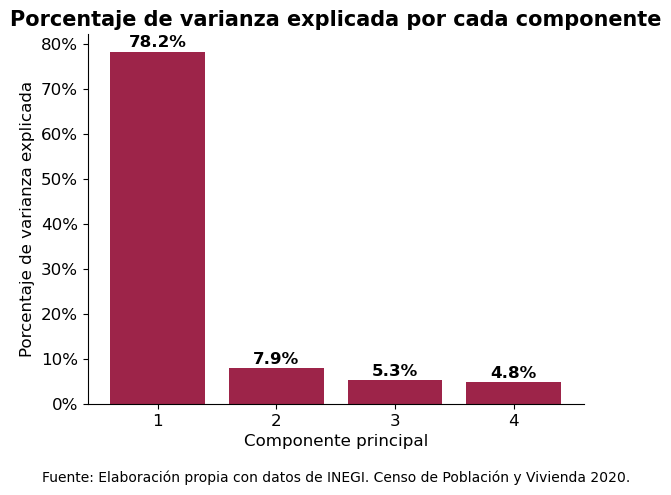

In [21]:
#Porcentaje de varianza explicada por cada componente
print(pca.explained_variance_ratio_)
#Gráfica de barras de varianza explicada
plt.bar(range(1,5),pca.explained_variance_ratio_,color='#9d2449',align='center')
plt.title('Porcentaje de varianza explicada por cada componente', fontsize=15, fontweight='bold')
plt.xlabel('Componente principal')
plt.ylabel('Porcentaje de varianza explicada')
plt.xticks(range(1,5))
#etiquetas en la parte superior de las barras
for x,y in zip(range(1,5),pca.explained_variance_ratio_):
    plt.text(x,y+0.01,str(round(y*100,1))+'%',color='black',ha='center',fontweight='bold')
    #Eje y multiplicado por 100
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#Eliminar borde derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.text(0.5, -0.2, 'Fuente: Elaboración propia con datos de INEGI. Censo de Población y Vivienda 2020.', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)


In [22]:
#Suma de la varianza explicada por los componenntes 1 y 2   
print("La suma de la varianza explicada por los componentes 1 y 2 es "+str(round(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2]+pca.explained_variance_ratio_[3],2)))

La suma de la varianza explicada por los componentes 1 y 2 es 0.96


In [23]:
#Crear un índice de rezago habitacional con base en el primer y segundo componente principal
ind1=data[:,0]
ind2=data[:,1]
ind3=data[:,2]
ind4=data[:,3]
explained_variance=pca.explained_variance_ratio_
ind_rez=ind1*explained_variance[0]+ind2*explained_variance[1]+ind3*explained_variance[2]+ind4*explained_variance[3]
#Normalizar el índice de rezago habitacional
ind_rez=(ind_rez-ind_rez.min())/(ind_rez.max()-ind_rez.min())
df_limpia['ind_rez']=ind_rez


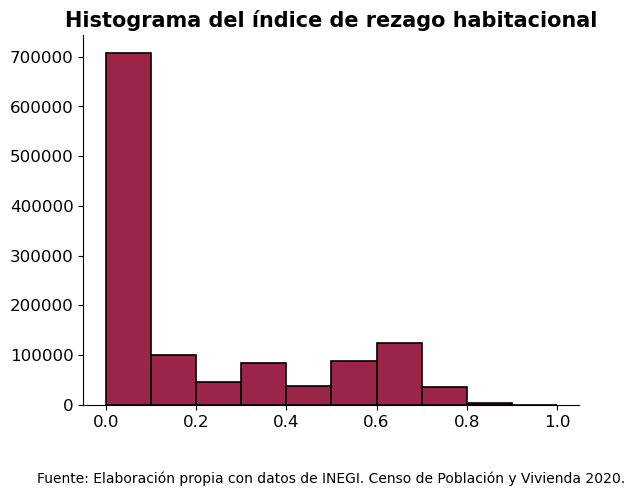

In [24]:
#Graficar el índice de rezago habitacional
plt.hist(ind_rez,bins=10,edgecolor='black', linewidth=1.2, color='#9d2449')
plt.title("Histograma del índice de rezago habitacional",fontsize=15, fontweight='bold')
#Evitar que eje y tenga notación científica
plt.ticklabel_format(style='plain', axis='y')
#Eliminar borde derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.text(0.5, -0.2, 'Fuente: Elaboración propia con datos de INEGI. Censo de Población y Vivienda 2020.', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [25]:
min_values = df_limpia[['p_viv_snexc', 'p_viv_ptierra', 'p_viv_hacina', 'p_viv_sagua', 'p_viv_energia', 'p_viv_drena', 'vialidad_sinrec']].min()
range_values = df_limpia[['p_viv_snexc', 'p_viv_ptierra', 'p_viv_hacina', 'p_viv_sagua', 'p_viv_energia', 'p_viv_drena', 'vialidad_sinrec']].max() - min_values
df_limpia_norm = (df_limpia[['p_viv_snexc', 'p_viv_ptierra', 'p_viv_hacina', 'p_viv_sagua', 'p_viv_energia', 'p_viv_drena','vialidad_sinrec']] - min_values) / range_values

# Suponiendo pesos iguales para cada indicador
weights = [1/7] * 7

# Cálculo del índice como el promedio ponderado de los indicadores normalizados
df_limpia['slum_severity_index'] = df_limpia_norm.dot(weights)

In [26]:
df_limpia

,cvegeo,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,...,p_viv_snexc,p_viv_ptierra,p_viv_hacina,p_viv_sagua,p_viv_drena,p_viv_energia,vialidad_sinrec,rasgos_mza,ind_rez,slum_severity_index
0,0100100010017001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,1,82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.879035e-13,0.000000
1,0100100010017002,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,2,83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000
2,0100100010017003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,3,84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.134115e-14,0.000000
3,0100100010017004,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,4,84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.971104e-13,0.000000
4,0100100010017005,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,5,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.974887e-13,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224778,3205800010123005,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,5,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000
1224779,3205800010123007,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,7,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000
1224780,3205800010123010,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,10,6,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1.712017e-01,0.035714
1224781,3205800010123013,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,13,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000


Text(0.5, -0.2, 'Fuente: Elaboración propia con datos de INEGI. Censo de Población y Vivienda 2020.')

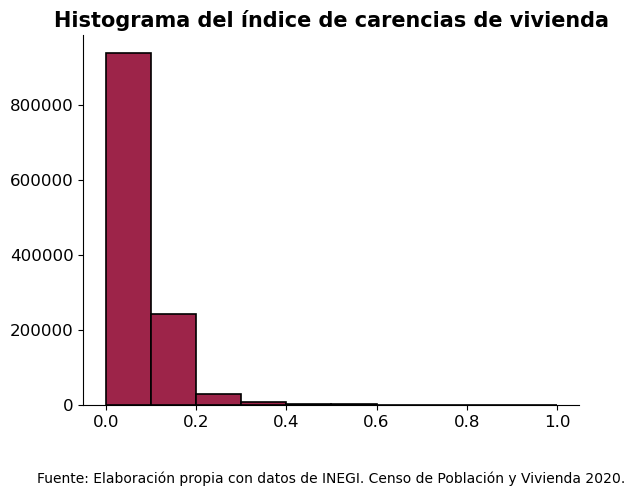

In [27]:
#GHistograma del slum severity index
plt.hist(df_limpia['slum_severity_index'],bins=10,edgecolor='black', linewidth=1.2, color='#9d2449')
plt.title("Histograma del índice de carencias de vivienda",fontsize=15, fontweight='bold')
#Evitar que eje y tenga notación científica
plt.ticklabel_format(style='plain', axis='y')
#Eliminar borde derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.text(0.5, -0.2, 'Fuente: Elaboración propia con datos de INEGI. Censo de Población y Vivienda 2020.', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)

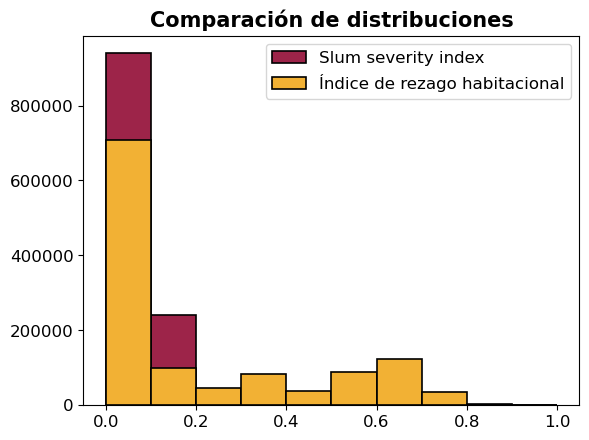

In [28]:
#Comparar la distribución del índice de rezago habitacional y el slum severity index
plt.hist(df_limpia['slum_severity_index'],bins=10,edgecolor='black', linewidth=1.2, color='#9d2449',label='Slum severity index')
plt.hist(df_limpia['ind_rez'],bins=10,edgecolor='black', linewidth=1.2, color='#f2b134',label='Índice de rezago habitacional')
plt.title("Comparación de distribuciones",fontsize=15, fontweight='bold')
plt.legend()
#Evitar que eje y tenga notación científica
plt.ticklabel_format(style='plain', axis='y')

In [29]:
#Número de ceros en el slu severity index
print("El número de ceros en el slum severity index es "+str(df_limpia[df_limpia['slum_severity_index']==0].shape[0]))
#Porcentaje
print("El porcentaje de ceros en el slum severity index es "+str(round(df_limpia[df_limpia['slum_severity_index']==0].shape[0]/df_limpia.shape[0]*100,2))+"%")

El número de ceros en el slum severity index es 602220
El porcentaje de ceros en el slum severity index es 49.17%


In [30]:
#Obtener 30 primeros registros con mayor rezago habitacional. Mostrar entidad, nom_ent, mun, nom_mun, lc, nom_loc, ind_rez
df_limpia.sort_values(by='ind_rez',ascending=False).head(60)[['entidad','nom_ent','mun','nom_mun','loc','nom_loc','p_viv_snexc','p_viv_ptierra','p_viv_hacina','ind_rez','slum_severity_index']]

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez,slum_severity_index
1050206,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,100.000000,100.000000,100.000000,1.000000,1.000000
1050511,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,100.000000,100.000000,100.000000,1.000000,1.000000
1050598,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,100.000000,100.000000,100.000000,1.000000,1.000000
1152983,30,Veracruz de Ignacio de la Llave,160,Álamo Temapache,1,Álamo,100.000000,100.000000,100.000000,0.994296,0.857143
1050193,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,100.000000,100.000000,100.000000,0.994296,0.857143
55508,2,Baja California,6,San Quintín,248,Emiliano Zapata,100.000000,75.000000,100.000000,0.989111,0.964286
1050198,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,100.000000,75.000000,100.000000,0.989111,0.964286
980031,26,Sonora,18,Cajeme,403,Pueblo Yaqui,75.000000,100.000000,100.000000,0.983750,0.821429
980033,26,Sonora,18,Cajeme,403,Pueblo Yaqui,58.333333,100.000000,100.000000,0.978145,0.833333
1050196,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,100.000000,81.818182,90.909091,0.977500,0.922078


In [31]:
#Obtener 30 primeros registros con mayor rezago habitacional. Mostrar entidad, nom_ent, mun, nom_mun, lc, nom_loc, ind_rez
df_limpia[(df_limpia['entidad']==12)].sort_values(by='ind_rez',ascending=False).head(30)[['entidad','nom_ent','mun','nom_mun','loc','nom_loc','p_viv_snexc','p_viv_ptierra','p_viv_hacina','ind_rez','slum_severity_index']]

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez,slum_severity_index
374765,12,Guerrero,29,Chilpancingo de los Bravo,1,Chilpancingo de los Bravo,0.000000,100.000000,83.333333,0.934951,0.690476
378743,12,Guerrero,35,Iguala de la Independencia,1,Iguala de la Independencia,0.000000,87.500000,87.500000,0.922291,0.642857
376493,12,Guerrero,35,Iguala de la Independencia,1,Iguala de la Independencia,0.000000,100.000000,71.428571,0.909545,0.632653
369427,12,Guerrero,21,Coyuca de Benítez,1,Coyuca de Benítez,0.000000,0.000000,100.000000,0.908556,0.571429
364630,12,Guerrero,1,Acapulco de Juárez,1,Acapulco de Juárez,60.000000,80.000000,100.000000,0.907734,0.600000
364611,12,Guerrero,1,Acapulco de Juárez,1,Acapulco de Juárez,0.000000,100.000000,100.000000,0.906087,0.571429
382777,12,Guerrero,46,Ometepec,1,Ometepec,0.000000,100.000000,100.000000,0.906087,0.571429
374735,12,Guerrero,29,Chilpancingo de los Bravo,1,Chilpancingo de los Bravo,57.142857,71.428571,42.857143,0.904939,0.673469
387523,12,Guerrero,57,Técpan de Galeana,59,Papanoa,0.000000,60.000000,80.000000,0.904893,0.600000
368977,12,Guerrero,19,Copalillo,1,Copalillo,29.411765,58.823529,58.823529,0.904190,0.638655


In [32]:
#Mostrar los 50 municipios con menor rezago habitacional
df_limpia.sort_values(by='ind_rez',ascending=True).head(100)[['entidad','nom_ent','mun','nom_mun','loc','nom_loc','p_viv_snexc','p_viv_ptierra','p_viv_hacina','ind_rez','slum_severity_index']]

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_viv_snexc,p_viv_ptierra,p_viv_hacina,ind_rez,slum_severity_index
1,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0.0,0.0,0.0,0.000000e+00,0.0
2,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0.0,0.0,0.0,3.134115e-14,0.0
0,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0.0,0.0,0.0,2.879035e-13,0.0
3,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0.0,0.0,0.0,2.971104e-13,0.0
4,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0.0,0.0,0.0,2.974887e-13,0.0
...,...,...,...,...,...,...,...,...,...,...,...
527486,15,México,33,Ecatepec de Morelos,1,Ecatepec de Morelos,0.0,0.0,0.0,2.978671e-13,0.0
527487,15,México,33,Ecatepec de Morelos,1,Ecatepec de Morelos,0.0,0.0,0.0,2.978671e-13,0.0
527488,15,México,33,Ecatepec de Morelos,1,Ecatepec de Morelos,0.0,0.0,0.0,2.978671e-13,0.0
527489,15,México,33,Ecatepec de Morelos,1,Ecatepec de Morelos,0.0,0.0,0.0,2.978671e-13,0.0


In [33]:
#Contar número de registros de Aguascalientes
df_limpia[(df_limpia['entidad']==12)].shape[0]

38359

In [34]:
#Si ind_rez es menor o igual a 0.05 entonces es "sin carencia", si no, es "con carencia"
df_limpia['rezago_c']=np.where(df_limpia['slum_severity_index']==0,'sin carencia','con carencia')

In [35]:
#Contar número de registros con rezago habitacional menor o igual a 0.3
print("El número de registros con rezago habitacional menor o igual a 0.3 es "+str(df_limpia[df_limpia['ind_rez']<=0.02].shape[0]))
#Porcentaje de registros con rezago habitacional menor o igual a 0.3
print("El porcentaje de registros con rezago habitacional menor o igual a 0.3 es "+str(round(df_limpia[df_limpia['ind_rez']<=0.02].shape[0]/df_limpia.shape[0]*100,1))+"%")

El número de registros con rezago habitacional menor o igual a 0.3 es 662325
El porcentaje de registros con rezago habitacional menor o igual a 0.3 es 54.1%


In [36]:
df_limpia

,cvegeo,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,...,p_viv_ptierra,p_viv_hacina,p_viv_sagua,p_viv_drena,p_viv_energia,vialidad_sinrec,rasgos_mza,ind_rez,slum_severity_index,rezago_c
0,0100100010017001,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,1,82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.879035e-13,0.000000,sin carencia
1,0100100010017002,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,2,83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,sin carencia
2,0100100010017003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,3,84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.134115e-14,0.000000,sin carencia
3,0100100010017004,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,4,84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.971104e-13,0.000000,sin carencia
4,0100100010017005,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,0017,5,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.974887e-13,0.000000,sin carencia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224778,3205800010123005,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,5,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000,sin carencia
1224779,3205800010123007,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,7,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000,sin carencia
1224780,3205800010123010,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,10,6,...,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1.712017e-01,0.035714,con carencia
1224781,3205800010123013,32,Zacatecas,58,Santa María de la Paz,1,Santa María de la Paz,0123,13,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000,sin carencia


In [37]:
#Ordenar de mayor a menor rezago
df_limpia=df_limpia.sort_values(by='slum_severity_index',ascending=False)
df_limpia

,cvegeo,entidad,nom_ent,mun,nom_mun,loc,nom_loc,ageb,mza,vivtot,...,p_viv_ptierra,p_viv_hacina,p_viv_sagua,p_viv_drena,p_viv_energia,vialidad_sinrec,rasgos_mza,ind_rez,slum_severity_index,rezago_c
1050206,2802200014004051,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,4004,51,27,...,100.0,100.0,100.0,100.0,100.0,100.0,0.0,1.000000e+00,1.000000,con carencia
1050598,2802200014729045,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,4729,45,11,...,100.0,100.0,100.0,100.0,100.0,100.0,0.0,1.000000e+00,1.000000,con carencia
1050511,2802200014517029,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,4517,29,19,...,100.0,100.0,100.0,100.0,100.0,100.0,0.0,1.000000e+00,1.000000,con carencia
1050593,2802200014729018,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,4729,18,12,...,100.0,75.0,100.0,100.0,100.0,100.0,0.0,9.742605e-01,0.964286,con carencia
1050198,2802200014004032,28,Tamaulipas,22,Matamoros,1,Heroica Matamoros,4004,32,22,...,75.0,100.0,100.0,100.0,100.0,100.0,0.0,9.891114e-01,0.964286,con carencia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710086,1901800010550007,19,Nuevo León,18,García,1,García,0550,7,38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000,sin carencia
710087,1901800010550008,19,Nuevo León,18,García,1,García,0550,8,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000,sin carencia
710088,1901800010550009,19,Nuevo León,18,García,1,García,0550,9,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000,sin carencia
710089,1901800010550010,19,Nuevo León,18,García,1,García,0550,10,34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978671e-13,0.000000,sin carencia


In [38]:
#filtrar df_limpia para el estado de Guerrero
df_guerrero=df_limpia[df_limpia['entidad']==12]

In [39]:
#filtrar df_limpia para el estado de Guerrero, Oaxaca, Puebla y Veracruz
#df_guerrero=df_limpia[(df_limpia['entidad']==12) | (df_limpia['entidad']==20) | (df_limpia['entidad']==21)]

In [40]:
df_guerrero["cvegeo"].info()

<class 'pandas.core.series.Series'>
Index: 38359 entries, 374765 to 355561
Series name: cvegeo
Non-Null Count  Dtype 
--------------  ----- 
38359 non-null  object
dtypes: object(1)
memory usage: 599.4+ KB


In [41]:
df_guerrero["entidad"].unique()

array([12], dtype=int64)

### Procesamiento de datos geográficos e imágenes satelitales

In [42]:
# descarga_manzanas=[{"url": "https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/30_veracruzignaciodelallave.zip",
#                         "filename": "30_veracruzignaciodelallave.zip",
#                         "check_file_path": "datos/conjunto_de_datos/30m.shp",
#                         "extract_path": "datos"}]
# for file in descarga_manzanas:
#     download_and_extract(file["url"], file["filename"], file["check_file_path"], file["extract_path"])

In [43]:
# url="https://www.inegi.org.mx/contenido/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/imagen_terri/geomediana_landsat/gm_2020_MX_017012_t.zip"
# filename="gm_2020-01-01-2020_11_30_MX_017012.tif"
# check_file_path="datos/MX_017012"
# extract_path="datos"
# download_and_extract(url, filename, check_file_path, extract_path)

In [44]:
# url="https://www.inegi.org.mx/contenido/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/imagen_terri/geomediana_landsat/gm_2020_MX_017012_t.zip"
# filename="gm_2020-01-01-2020_11_30_MX_017012.tif"
# check_file_path="datos/MX_017012"
# extract_path="datos"
# download_and_extract(url, filename, check_file_path, extract_path)

PROJCS["Albers",GEOGCS["GCS_GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",12],PARAMETER["longitude_of_center",-102],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Text(0.5, 1.0, 'Imagen de Guerrero, 2020')

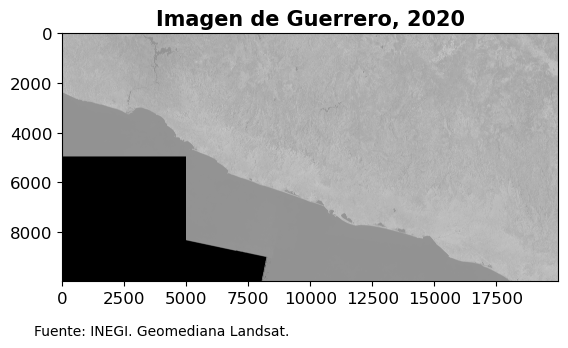

In [45]:
#image_path="datos/MX_017012/gm_2020-01-01-2020_11_30_MX_017012.tif"
image_path="datos/output/mosaic_output.tif"
#image_path="datos/output/uso_suelo.tif"
with rasterio.open(image_path) as src:
    band4 = src.read(4)  # Assuming the 4th band is the one of interest
    transform = src.transform
    crs = src.crs

#Imprimir crs
print(crs)

#Mostrar la imagen
plt.imshow(band4, cmap='Greys_r')
plt.text(0.2, -0.2, 'Fuente: INEGI. Geomediana Landsat.', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)
plt.title("Imagen de Guerrero, 2020",fontsize=15, fontweight='bold')

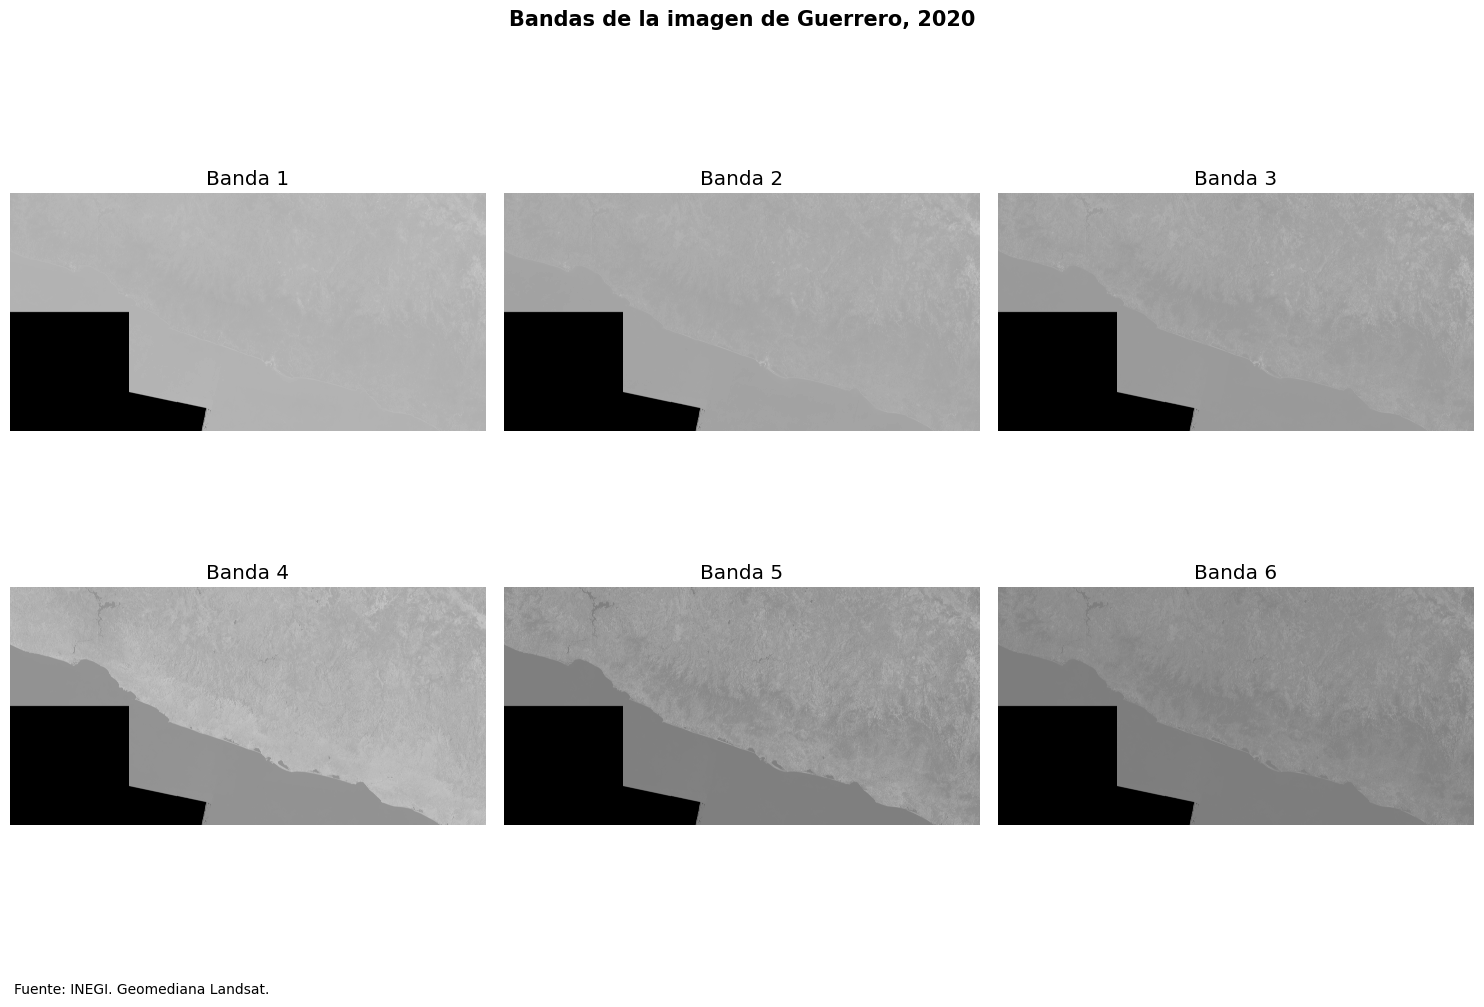

In [46]:
# Open the dataset
with rasterio.open(image_path) as src:
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Bandas de la imagen de Guerrero, 2020", fontsize=15, fontweight='bold')  # Set the title for the entire figure

    # Loop through each band
    for i in range(1, 7):
        # Read the band data
        band_data = src.read(i)
        
        # Plot the band data
        ax = axs[(i-1) // 3, (i-1) % 3]
        ax.imshow(band_data, cmap='Greys_r')
        ax.set_title(f'Banda {i}')
        ax.axis('off')
    
    plt.tight_layout()

    # Set the source text
    plt.text(0.1,0, 'Fuente: INEGI. Geomediana Landsat.', fontsize=10, ha='center', va='center', transform=fig.transFigure)
    plt.show()


In [47]:
# import matplotlib.pyplot as plt
# import rasterio
# combinada="datos/output/uso_suelo.tif"
# 
# # Since the user wants to see a single image composed of all bands,
# # we will combine the bands into one image.
# # We'll check the number of bands again and stack them in the correct order.
# 
# with rasterio.open(combinada) as src:
#     # Reading all bands
#     bands = src.read()
#     transform = src.transform
#     crs = src.crs
# 
# # Check if the bands can be combined into a standard RGB image
# if bands.shape[0] >= 3:
#     # We assume that the first three bands correspond to Blue, Green, and Red, respectively.
#     # This is a common configuration for multispectral data, but may not be accurate for all images.
#     rgb = np.stack((bands[2], bands[1], bands[0]), axis=-1)
# else:
#     # If there are not enough bands for RGB, we will simply display the first band
#     rgb = bands[0]
# 
# # Show the combined image
# plt.figure(figsize=(10, 8))
# plt.imshow(rgb)
# plt.title('Combined Image')
# plt.show()


In [48]:
#leer shape de manzanas
# manzana1=gpd.read_file("datos/conjunto_de_datos/12m.shp")
# manzana2=gpd.read_file("datos/conjunto_de_datos/20m.shp")
# manzana3=gpd.read_file("datos/conjunto_de_datos/21m.shp")
#manzana4=gpd.read_file("datos/conjunto_de_datos/30m.shp")
#Pegar manzanas
#manzanas=pd.concat([manzana1,manzana2,manzana3],axis=0)
#Volverlo geodataframe
#manzanas=gpd.GeoDataFrame(manzanas)
manzanas=gpd.read_file("datos/conjunto_de_datos/12m.shp")
#Reproyectar a crs de la imagen
manzanas=manzanas.to_crs(crs)
#Convertir crs a wgs84
#manzanas = manzanas.to_crs(epsg=4326)
manzanas.columns=[i.lower() for i in manzanas.columns]
manzanas=pd.merge(manzanas,df_guerrero,how="left",on="cvegeo")
#Eliminar nans
manzanas=manzanas[manzanas['slum_severity_index'].notna()]
#Filtrar para municipio de Acapulco o de Coyuca de Benítez
# manzanas=manzanas[(manzanas['cve_mun']=='001') | (manzanas["cve_mun"]=='012') | 
#                   (manzanas['cve_mun']=='021') | (manzanas["cve_mun"]=="028") |
#                   (manzanas["cve_mun"]=='029')| (manzanas["cve_mun"]=="030")]

#Cambiar tipo de datos de rezago_c de categoría a string
manzanas['rezago_c']=manzanas['rezago_c'].astype(str)
#Crear una variable klass con el valor de rezago_c. Tiene que ser un entero de 1 a 5
#manzanas['klass']=manzanas['rezago_c'].replace({'muy bajo':1,'bajo':2,'medio':3,'alto':4,'muy alto':5})
#Ordenar de mayor a menor rezago
manzanas=manzanas.sort_values(by='slum_severity_index',ascending=False)
print(manzanas.crs)
manzanas

PROJCS["Albers",GEOGCS["GCS_GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",12],PARAMETER["longitude_of_center",-102],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


,cvegeo,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,ambito,tipomza,geometry,entidad,...,p_viv_ptierra,p_viv_hacina,p_viv_sagua,p_viv_drena,p_viv_energia,vialidad_sinrec,rasgos_mza,ind_rez,slum_severity_index,rezago_c
47163,1202900013453009,12,029,0001,3453,009,Urbana,Típica,"POLYGON ((2764651.966 616127.412, 2764585.475 ...",12.0,...,100.000000,83.333333,100.0,100.000000,0.0,100.000000,0.000000,9.349514e-01,0.690476,con carencia
82322,1206100060102006,12,061,0006,0102,006,Urbana,Típica,"POLYGON ((2777821.794 624366.579, 2777818.456 ...",12.0,...,100.000000,0.000000,100.0,100.000000,0.0,75.000000,20.000000,7.201364e-01,0.678571,con carencia
74885,1205500460586035,12,055,0046,0586,035,Urbana,Típica,"POLYGON ((2762850.373 718142.586, 2762848.448 ...",12.0,...,100.000000,100.000000,100.0,100.000000,0.0,75.000000,0.000000,7.809093e-01,0.678571,con carencia
47976,1202900013434008,12,029,0001,3434,008,Urbana,Típica,"POLYGON ((2765116.723 615998.508, 2765189.343 ...",12.0,...,71.428571,42.857143,100.0,100.000000,0.0,100.000000,20.000000,9.049395e-01,0.673469,con carencia
19114,1200100016993005,12,001,0001,6993,005,Urbana,Típica,"POLYGON ((2728067.352 540349.366, 2728081.151 ...",12.0,...,83.333333,100.000000,100.0,83.333333,0.0,91.666667,29.411765,8.801140e-01,0.654762,con carencia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60517,1203800010782018,12,038,0001,0782,018,Urbana,Típica,"POLYGON ((2546946.831 622165.137, 2546938.154 ...",12.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.978671e-13,0.000000,sin carencia
60520,1203800010710004,12,038,0001,0710,004,Urbana,Típica,"POLYGON ((2548913.535 621663.342, 2548909.390 ...",12.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.978671e-13,0.000000,sin carencia
60522,1203800010710002,12,038,0001,0710,002,Urbana,Típica,"POLYGON ((2548602.138 621372.482, 2548688.630 ...",12.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.978671e-13,0.000000,sin carencia
60523,1203800010710001,12,038,0001,0710,001,Urbana,Típica,"POLYGON ((2548571.097 621496.299, 2548582.146 ...",12.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.978671e-13,0.000000,sin carencia


In [49]:
manzanas["rezago_c"].unique()

array(['con carencia', 'sin carencia'], dtype=object)

In [50]:
# # Satellite image path
# image_path="datos/MX_016013/gm_2020-01-01-2020_11_30_MX_016013.tif"


# tamgrid=1000
# # Read the satellite image
# with rasterio.open(image_path) as src:
#     band4 = src.read(4)  # Assuming the 4th band is the one of interest
#     transform = src.transform
#     crs = src.crs

#     # Determine the size of the grid cells in pixels
#     grid_size_x = max(1, round(tamgrid / src.transform[0]))
#     grid_size_y = max(1, round(tamgrid / src.transform[4]))

#     # Initialize a list to hold our geometries
#     grid_polygons = []

#     for row in range(0, band4.shape[0], grid_size_y):
#         for col in range(0, band4.shape[1], grid_size_x):
#             # Calculate the spatial coordinates for the grid cell
#             left, top = src.transform * (col, row)
#             right, bottom = src.transform * (col + grid_size_x, row + grid_size_y)
#             grid_polygons.append(box(left, bottom, right, top))


In [51]:
import rasterio
from shapely.geometry import box

# Satellite image path
#image_path = "datos/MX_017012/gm_2020-01-01-2020_11_30_MX_017012.tif"

# Define the size of the grid in meters (or any other unit of measurement)
tamgrid = 200  # Adjust this value as needed

# Read the satellite image
with rasterio.open(image_path) as src:
    band4 = src.read(4)  # Assuming the 4th band is the one of interest
    transform = src.transform
    crs = src.crs

    # Calculate the pixel size in X and Y dimensions
    pixel_size_x = src.transform[0]
    pixel_size_y = -src.transform[4]  # Negative because Y pixel size is often stored as a negative value

    # Calculate the number of pixels that correspond to the desired grid size
    grid_size_x = max(1, round(tamgrid / pixel_size_x))
    grid_size_y = max(1, round(tamgrid / pixel_size_y))

    # Adjust grid size to compensate for non-uniform scaling (if necessary)
    # This step might require some trial and error or specific calculations based on the image characteristics

    # Initialize a list to hold our geometries
    grid_polygons = []

    for row in range(0, band4.shape[0], grid_size_y):
        for col in range(0, band4.shape[1], grid_size_x):
            # Calculate the spatial coordinates for the grid cell
            left, top = src.transform * (col, row)
            right, bottom = src.transform * (col + grid_size_x, row + grid_size_y)
            grid_polygons.append(box(left, bottom, right, top))

# The grid_polygons list now contains the desired grid cells


In [52]:
# Create a GeoDataFrame from the grid polygons
grid_gdf = gpd.GeoDataFrame({'geometry': grid_polygons}, crs=crs)

Text(-4, -0.1, 'Fuente: Elaboración propia con información de INEGI. Geomediana Landsat.')

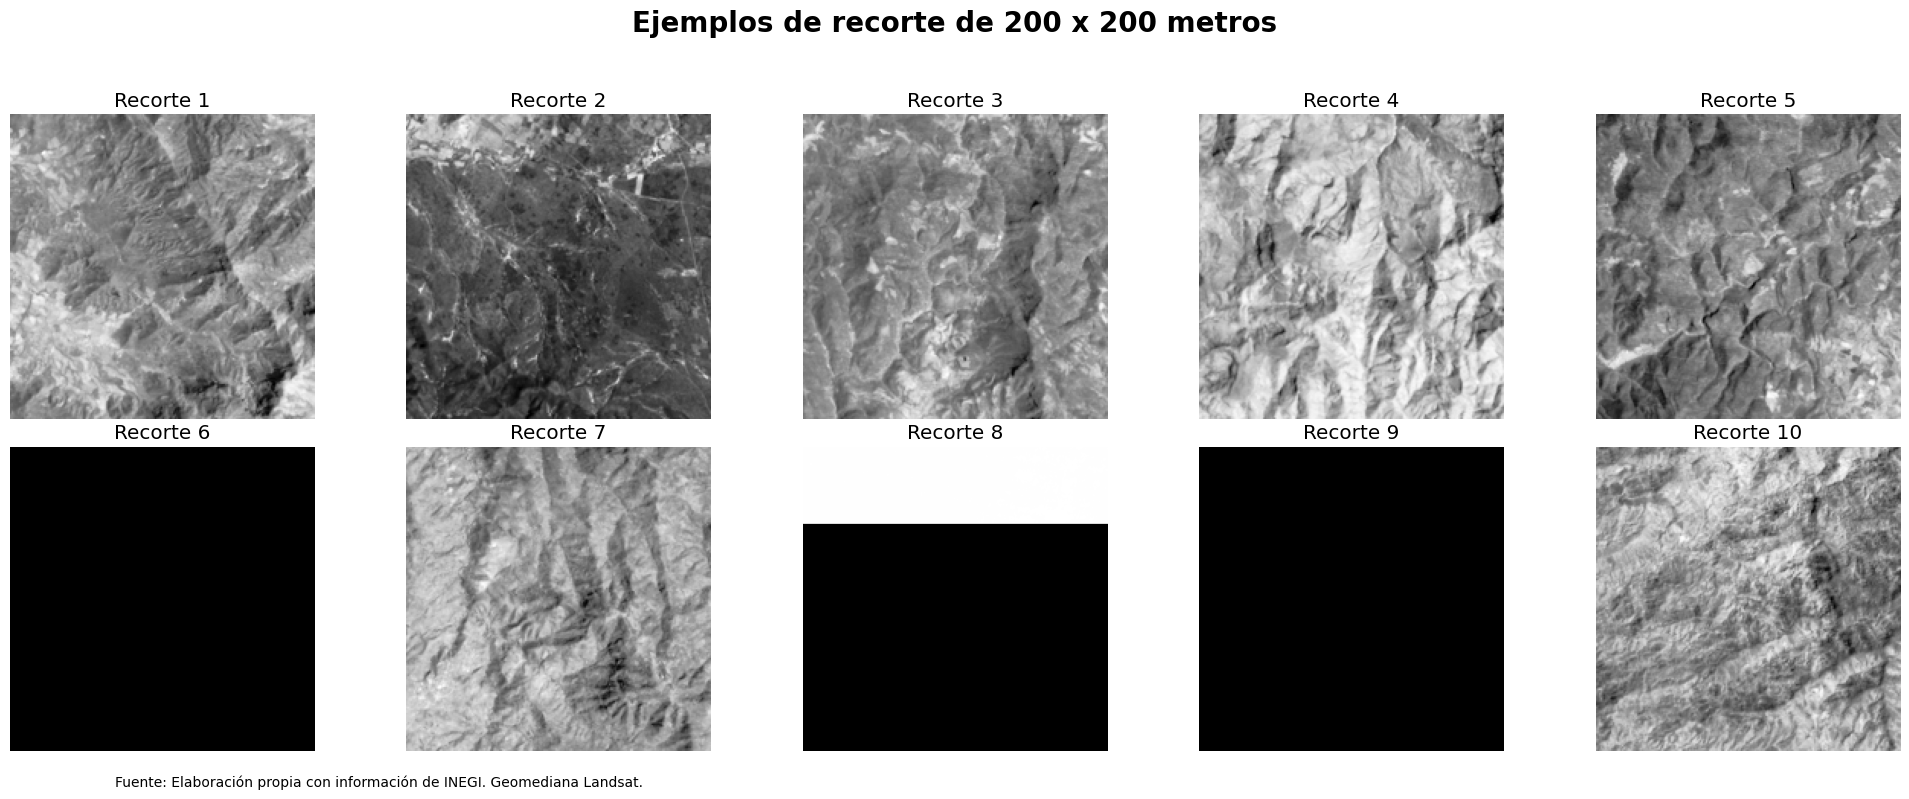

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Since we're working with simulated data in this environment, let's simulate a smaller 'band4' array

# Function to generate random crops of 1000x1000 from the band4 data
def generate_random_crops(image, crop_size, num_crops):
    crops = []
    height, width = image.shape
    for _ in range(num_crops):
        # Randomly choose a top-left corner for the crop
        start_x = np.random.randint(0, width - crop_size)
        start_y = np.random.randint(0, height - crop_size)
        # Extract the crop and add it to the list
        crop = image[start_y:start_y + crop_size, start_x:start_x + crop_size]
        crops.append(crop)
    return crops

# Generate 10 random crops of size 1000x1000
random_crops = generate_random_crops(band4, 200, 10)

# Plot the crops in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows and 5 columns to accommodate 10 images
fig.suptitle('Ejemplos de recorte de 200 x 200 metros', fontsize=20,fontweight='bold')

for i, crop in enumerate(random_crops):
    row = i // 5  # Determine the row of the subplot
    col = i % 5   # Determine the column of the subplot
    axes[row, col].imshow(crop, cmap='Greys_r')
    axes[row, col].set_title(f'Recorte {i+1}')
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the super title

#Fuente
plt.text(-4, -0.1, 'Fuente: Elaboración propia con información de INEGI. Geomediana Landsat.', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)


In [54]:
print(grid_gdf.total_bounds)
print(manzanas.total_bounds)

[2400000.  449910. 3000180.  750000.]
[2487872.38919135  488745.77983765 2908298.78142456  746177.6971827 ]


In [55]:
joined_gdf = gpd.sjoin(grid_gdf, manzanas, how='left', predicate='intersects')
joined_gdf=joined_gdf.reset_index()
len(joined_gdf)

4159617

In [98]:
#Contar reistros de rezago_c sin carencia y con carencia omitiendo nans
print("La suma de de registros con carencia y sin carencia es "+str(joined_gdf['rezago_c'].count()))

La suma de de registros con carencia y sin carencia es 92495


In [57]:
joined_gdf

,index,geometry,index_right,cvegeo,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,ambito,...,p_viv_ptierra,p_viv_hacina,p_viv_sagua,p_viv_drena,p_viv_energia,vialidad_sinrec,rasgos_mza,ind_rez,slum_severity_index,rezago_c
0,0,"POLYGON ((2400210.000 749790.000, 2400210.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"POLYGON ((2400420.000 749790.000, 2400420.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"POLYGON ((2400630.000 749790.000, 2400630.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"POLYGON ((2400840.000 749790.000, 2400840.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"POLYGON ((2401050.000 749790.000, 2401050.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4159612,4084077,"POLYGON ((2999340.000 449910.000, 2999340.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4159613,4084078,"POLYGON ((2999550.000 449910.000, 2999550.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4159614,4084079,"POLYGON ((2999760.000 449910.000, 2999760.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4159615,4084080,"POLYGON ((2999970.000 449910.000, 2999970.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
base_mapa=joined_gdf.copy()
#Eliminar nans de rezago_c
base_mapa=base_mapa[base_mapa['rezago_c'].notna()]
#Crs a wgs84
base_mapa=base_mapa.to_crs(epsg=4326)

#Hacer una copia de manzanas
manzanasmapa=manzanas.copy()
#Eliminar nanss de manzanasmapa
manzanasmapa=manzanasmapa[manzanasmapa['rezago_c'].notna()]
#Crs a wgs84
manzanasmapa=manzanasmapa.to_crs(epsg=4326)

In [59]:
import folium

etiqueta_color = {
    'sin carencia': '#ffffb2',
    
    'con carencia': '#bd0026'
}


# Create the Folium map centered on the given location
m = folium.Map(location=[17.6018995, -100.0958137], zoom_start=9,control_scale=True, tiles=None)

# Add the Google Satellite tile layer
folium.TileLayer(
    tiles='http://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}',
    attr="@claudiodanielpc con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020",
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# Function to get the color based on 'klass'
def get_color(feature):
    klass = feature['properties']['rezago_c']
    return etiqueta_color.get(klass, '#000000')

#Grupo cuadricula
cuadricula = folium.FeatureGroup(name='Cuadricula')
# Add GeoJSON to the map with style and tooltip
folium.GeoJson(
    base_mapa.to_json(),
    style_function=lambda feature: {
        'fillColor': get_color(feature),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['rezago_c'],
        aliases=['Etiqueta:'],
        localize=False  # Non-localizable content
    )
).add_to(cuadricula)

#Añadir al mapa
cuadricula.add_to(m)


#Agregar capa de copernicus1
manzanasgroup = folium.FeatureGroup(name="Manzanas",show=True)

folium.GeoJson(
    manzanasmapa.to_json(),
    style_function=lambda feature: {
        #Rellenar por grado de marginación
        'fillColor': get_color(feature),
        
        'fillOpacity': 0.5,
        'color': '#000000',   # You can adjust the border color if needed
        'weight': 1,
        'dashArray': '5, 5'  # Dashed borders, remove this if not desired
    },
tooltip=folium.GeoJsonTooltip(fields=["rezago_c"],aliases=['Etiqueta:'], localize=False)).add_to(manzanasgroup)

#Añadir al mapa
manzanasgroup.add_to(m)






# Define the HTML template for the legend
template = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 220px; height: 170px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.8; padding: 5px;">
    &nbsp; <b>Carencias de vivienda</b> <br>
    &nbsp; Sin carencia &nbsp; <i style="background: #ffffb2; width: 20px; height: 10px; display: inline-block;"></i><br>   
    &nbsp; Con carencia &nbsp; <i style="background: #bd0026; width: 20px; height: 10px; display: inline-block;"></i><br>
</div>
{% endmacro %}
"""



# Create a MacroElement which will be added to the map
macro = MacroElement()
macro._template = Template(template)

# Add the legend to the map
m.get_root().add_child(macro)


# Add layer control to toggle layers
folium.LayerControl().add_to(m)
#Salvar mapa
m.save('mapa_rezago_cuadricula.html')

In [60]:
# Read in the saved map HTML
with open("mapa_rezago_cuadricula.html", 'r') as file:
    html = file.read()

# Add a title tag; replace 'Your Map Title' with your desired title
title_tag = "<title>Etiquetado de cuadrículas utilizando imágenes satelitales</title>"
head_tag = "<head>"
# Insert the title tag after the head tag
html = html.replace(head_tag, head_tag + title_tag, 1)

# Write the modified HTML back to the file
with open("mapa_rezago_cuadricula.html", 'w') as file:
    file.write(html)

In [61]:
#salvar base_mapa como shapefile
base_mapa.to_file("datos/base_mapa_cuadr.shp")

C:\Users\claud\AppData\Local\Temp\ipykernel_46984\494201682.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  base_mapa.to_file("datos/base_mapa_cuadr.shp")


In [62]:
# Extract features from each grid cell
features_list = []
for index, geom in enumerate(joined_gdf.geometry):
    # Create a mask for the grid cell using rasterio's features module
    window = rasterio.features.geometry_window(src, [geom])

    # Read the band data within the window
    # Instead of using band4.read(...), directly index the band4 NumPy array
    window_transform = src.window_transform(window)
    band4_data = band4[window.row_off:window.row_off+window.height, window.col_off:window.col_off+window.width]

    # Exclude nodata values and calculate the mean
    nodata = src.nodatavals[0]  # Assuming nodata value is the same for all bands
    valid_data = band4_data[band4_data != nodata]
    mean_band4 = np.mean(valid_data) if valid_data.size > 0 else np.nan

    # Add the feature to the list
    features_list.append({'mean_band4': mean_band4})

# Convert the list of features to a DataFrame
features_df = pd.DataFrame(features_list)

# Add the rezago_c labels from the manzanas_gdf to the features DataFrame
features_df['rezago_c'] = joined_gdf['rezago_c']
# Eliminar nans
features_df=features_df[features_df['rezago_c'].notna()]
features_df

,mean_band4,rezago_c
53083,2869.510204,con carencia
53084,2869.510204,con carencia
53085,2869.346939,con carencia
53086,2869.346939,con carencia
53087,2869.346939,con carencia
...,...,...
3630280,2637.448980,con carencia
3630281,2637.448980,sin carencia
3630282,2393.122449,con carencia
3633138,2463.530612,sin carencia


In [63]:
joined_gdf

,index,geometry,index_right,cvegeo,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,ambito,...,p_viv_ptierra,p_viv_hacina,p_viv_sagua,p_viv_drena,p_viv_energia,vialidad_sinrec,rasgos_mza,ind_rez,slum_severity_index,rezago_c
0,0,"POLYGON ((2400210.000 749790.000, 2400210.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"POLYGON ((2400420.000 749790.000, 2400420.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"POLYGON ((2400630.000 749790.000, 2400630.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"POLYGON ((2400840.000 749790.000, 2400840.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"POLYGON ((2401050.000 749790.000, 2401050.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4159612,4084077,"POLYGON ((2999340.000 449910.000, 2999340.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4159613,4084078,"POLYGON ((2999550.000 449910.000, 2999550.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4159614,4084079,"POLYGON ((2999760.000 449910.000, 2999760.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4159615,4084080,"POLYGON ((2999970.000 449910.000, 2999970.000 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
#Contar por etiqueta
features_df['rezago_c'].value_counts()

rezago_c
con carencia    72849
sin carencia    19646
Name: count, dtype: int64

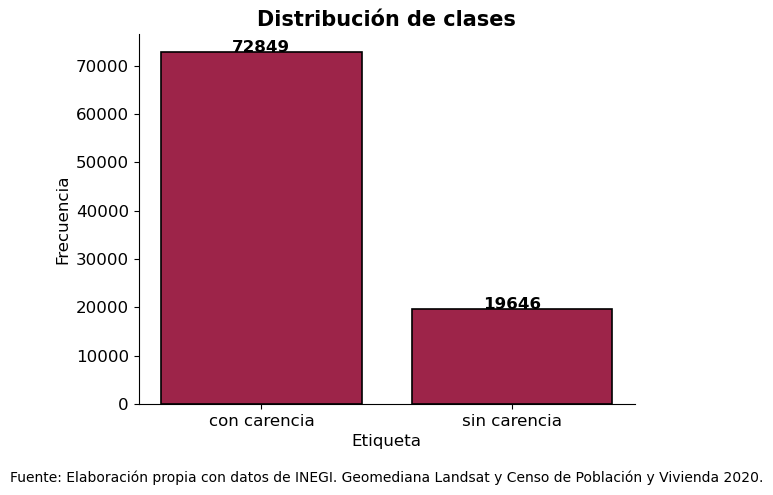

In [65]:
#Graficar la distribución de clases
plt.bar(features_df['rezago_c'].value_counts().index,features_df['rezago_c'].value_counts(),color='#9d2449',edgecolor='black', linewidth=1.2)
plt.title("Distribución de clases",fontsize=15, fontweight='bold')
plt.xlabel("Etiqueta")
plt.ylabel("Frecuencia")
#Eliminar borde derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.text(0.5, -0.2, 'Fuente: Elaboración propia con datos de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020.', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)
#Poner etiquetas en las barras
for x,y in zip(features_df['rezago_c'].value_counts().index,features_df['rezago_c'].value_counts()):
    plt.text(x,y+0.01,str(y),color='black',ha='center',fontweight='bold')

In [66]:
#Aplicar undersampling
from imblearn.under_sampling import RandomUnderSampler

In [67]:
#Aplicar sobresaampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### Modelos

In [68]:
# Prepare the data for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#Separar en X y y
X=features_df[['mean_band4']]
y=features_df['rezago_c'][X.index]
#Aplicar undersampling
# rus = RandomUnderSampler(random_state=0)
# X, y = rus.fit_resample(X, y)

ros=RandomOverSampler(random_state=0)
X,y=ros.fit_resample(X,y)

# smote=SMOTE(random_state=42)
# X,y=smote.fit_resample(X,y)

#Imprimir shape de X y y
print(X.shape)
print(y.shape)

# X = features_df[['mean_band4']]  # Using only mean_band4 as a feature
# y = features_df['rezago_c'][X.index]  # Corresponding labels, dropping any NaNs in X

(145698, 1)
(145698,)


In [69]:
#Hacer split de X y y en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [70]:
#Impprimir distribución de las etiquetas en y_train
print(y_train.value_counts())

rezago_c
sin carencia    58279
con carencia    58279
Name: count, dtype: int64


In [71]:
model = LogisticRegression(max_iter=100,solver='liblinear',class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
class_report = classification_report(y_test, y_pred, output_dict=True)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print(f'Classification report:\n{class_report}')
df_report = pd.DataFrame(class_report).transpose()
#Salvar reporte en excel
df_report.to_excel("reporte_regrlog.xlsx",index=False)

Accuracy: 56.09%
Classification report:
{'con carencia': {'precision': 0.5607367844426184, 'recall': 0.5620452985586822, 'f1-score': 0.5613902790155618, 'support': 14570.0}, 'sin carencia': {'precision': 0.561020913593836, 'recall': 0.5597117364447495, 'f1-score': 0.5603655603655603, 'support': 14570.0}, 'accuracy': 0.5608785175017158, 'macro avg': {'precision': 0.5608788490182273, 'recall': 0.5608785175017159, 'f1-score': 0.5608779196905611, 'support': 29140.0}, 'weighted avg': {'precision': 0.5608788490182272, 'recall': 0.5608785175017158, 'f1-score': 0.560877919690561, 'support': 29140.0}}


In [72]:
# Make predictions on the non-NaN subset of features
valid_indices = features_df.index  # indices of non-NaN records in features_df
y_pred_full = model.predict(features_df.loc[valid_indices, 'mean_band4'].values.reshape(-1, 1))
observados=joined_gdf.copy()
#Tirar nans de rezago_c
observados=observados[observados['rezago_c'].notna()]
observados=observados.to_crs(epsg=4326)
predobslog=joined_gdf.copy()
# Add the predictions to the corresponding records in joined_gdf
predobslog.loc[valid_indices, 'predictions'] = y_pred_full
predobslog = predobslog.loc[valid_indices]
#Eliminar columna de rezago_c
predobslog=predobslog.drop(columns=['rezago_c'])
predobslog
#crs a wgs84
predobslog=predobslog.to_crs(epsg=4326)

C:\Users\claud\miniconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [73]:
observados["rezago_c"].unique()

array(['con carencia', 'sin carencia'], dtype=object)

Text(0.5, -0.2, 'Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020')

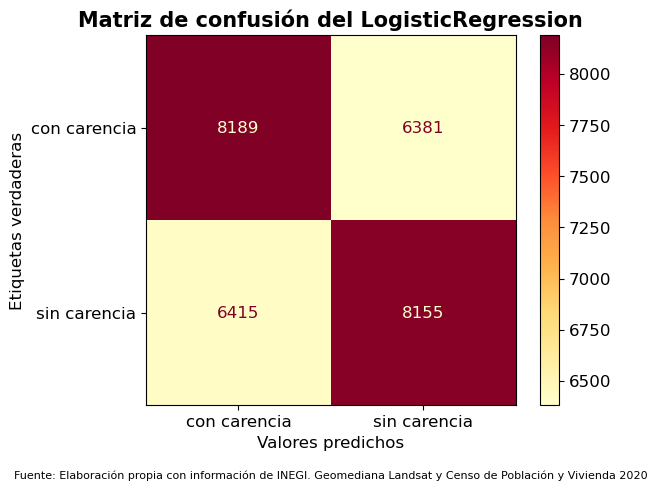

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix 
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

cmd.plot(cmap='YlOrRd')
cmd.ax_.set_title(f'Matriz de confusión del {model.__class__.__name__}', fontsize=15, fontweight='bold')
cmd.ax_.set_xlabel('Valores predichos')
cmd.ax_.set_ylabel('Etiquetas verdaderas')
#Fuente
cmd.ax_.text(0.5, -0.2, "Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020", size=8, ha="center", transform=cmd.ax_.transAxes)

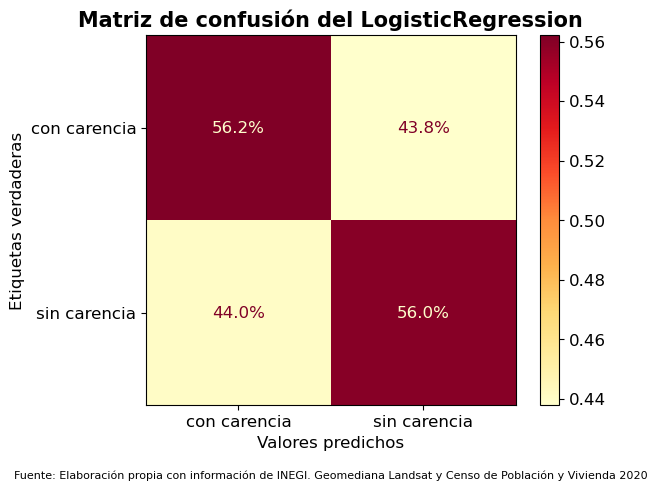

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Assuming 'y_test' are your true labels and 'y_pred' are your predicted labels

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix 
cmd = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.classes_)

cmd.plot(cmap='YlOrRd', values_format='.1%')  # Format as percentage
cmd.ax_.set_title(f'Matriz de confusión del {model.__class__.__name__}', fontsize=15, fontweight='bold')
cmd.ax_.set_xlabel('Valores predichos')
cmd.ax_.set_ylabel('Etiquetas verdaderas')
#Fuente
cmd.ax_.text(0.5, -0.2, "Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020", size=8, ha="center", transform=cmd.ax_.transAxes)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.3, 'AUC = 0.58')

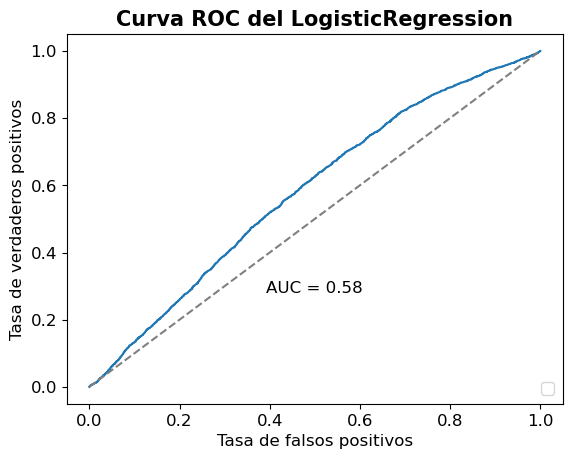

In [76]:
#Roc curve de las clasificaciones
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
# Get the predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]


from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_display.ax_.set_title(f'Curva ROC del {model.__class__.__name__}', fontsize=15, fontweight='bold')
roc_display.ax_.set_xlabel('Tasa de falsos positivos')
roc_display.ax_.set_ylabel('Tasa de verdaderos positivos')
#Diagonal
roc_display.ax_.plot([0, 1], [0, 1], color='grey', linestyle='--')
#Añadir AUC
roc_display.ax_.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}', size=12, ha="center", transform=roc_display.ax_.transAxes)

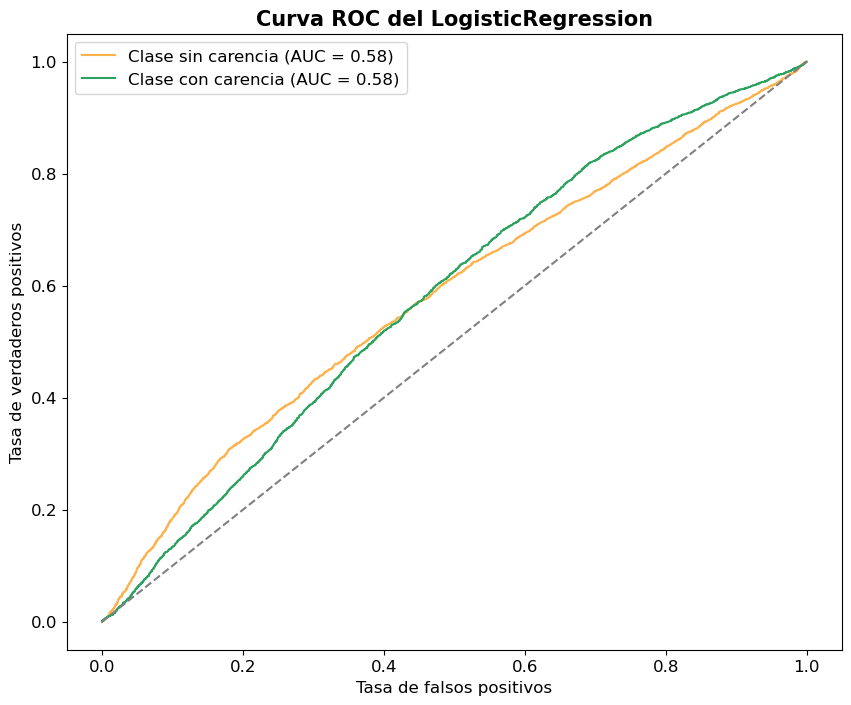

In [77]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'model' is your trained classification model and 'X_test', 'y_test' are your test data and labels

# Get the predicted probabilities
y_pred_proba1 = model.predict_proba(X_test)[:, 0]
y_pred_proba2 = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba1, pos_label=model.classes_[0])
fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba2, pos_label=model.classes_[1])

# Calculate AUC for each class
auc1 = roc_auc_score(y_test == model.classes_[0], y_pred_proba1)
auc2 = roc_auc_score(y_test == model.classes_[1], y_pred_proba2)

# Create a plot
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label=f'Clase sin carencia (AUC = {auc1:.2f})', color='#feb24c')  # ROC curve for class 1
plt.plot(fpr2, tpr2, label=f'Clase con carencia (AUC = {auc2:.2f})', color='#2ca25f')   # ROC curve for class 2
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')                              # Diagonal line

# Customize the plot
plt.title(f'Curva ROC del {model.__class__.__name__}', fontsize=15, fontweight='bold')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend(loc='best')

# Show the plot
plt.show()



In [78]:
#usar un modelo de bosque aleatorio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Create and train the random forest model
model = RandomForestClassifier( class_weight='balanced',random_state=42, max_depth=None)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print(f'Classification report:\n{class_report}')
df_report = pd.DataFrame(class_report).transpose()
#Salvar reporte en excel
df_report.to_excel("reporte_random_forest.xlsx",index=False)


Accuracy: 78.15%
Classification report:
{'con carencia': {'precision': 0.8267346451047558, 'recall': 0.7122855181880576, 'f1-score': 0.7652545809829296, 'support': 14570.0}, 'sin carencia': {'precision': 0.7472719599686501, 'recall': 0.8507206588881263, 'f1-score': 0.7956478479956349, 'support': 14570.0}, 'accuracy': 0.7815030885380919, 'macro avg': {'precision': 0.7870033025367029, 'recall': 0.781503088538092, 'f1-score': 0.7804512144892823, 'support': 29140.0}, 'weighted avg': {'precision': 0.787003302536703, 'recall': 0.7815030885380919, 'f1-score': 0.7804512144892822, 'support': 29140.0}}


Text(0.5, -0.2, 'Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020')

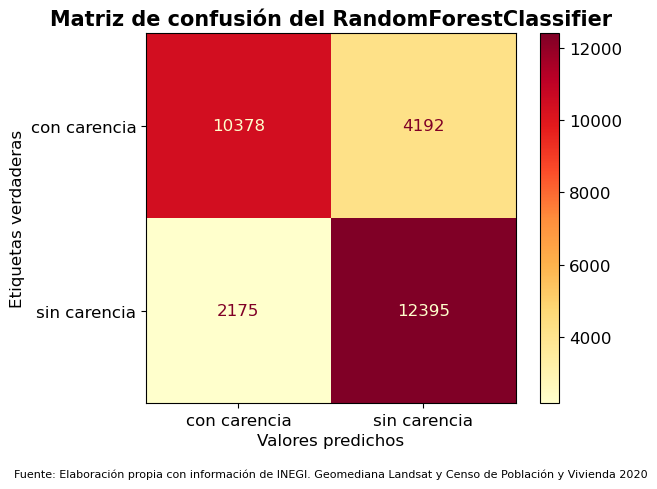

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix 
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

cmd.plot(cmap='YlOrRd', values_format='d')
cmd.ax_.set_title(f'Matriz de confusión del {model.__class__.__name__}', fontsize=15, fontweight='bold')
cmd.ax_.set_xlabel('Valores predichos')
cmd.ax_.set_ylabel('Etiquetas verdaderas')
#Fuente
cmd.ax_.text(0.5, -0.2, "Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020", size=8, ha="center", transform=cmd.ax_.transAxes)

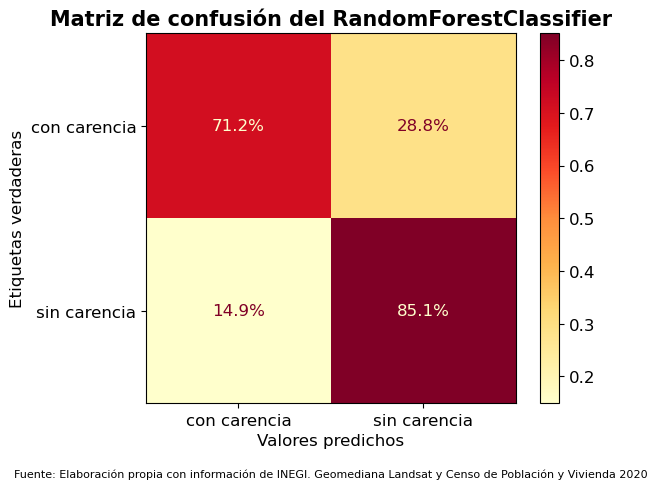

In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Assuming 'y_test' are your true labels and 'y_pred' are your predicted labels

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix 
cmd = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.classes_)

cmd.plot(cmap='YlOrRd', values_format='.1%')  # Format as percentage
cmd.ax_.set_title(f'Matriz de confusión del {model.__class__.__name__}', fontsize=15, fontweight='bold')
cmd.ax_.set_xlabel('Valores predichos')
cmd.ax_.set_ylabel('Etiquetas verdaderas')
#Fuente
cmd.ax_.text(0.5, -0.2, "Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020", size=8, ha="center", transform=cmd.ax_.transAxes)

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.3, 'AUC = 0.86')

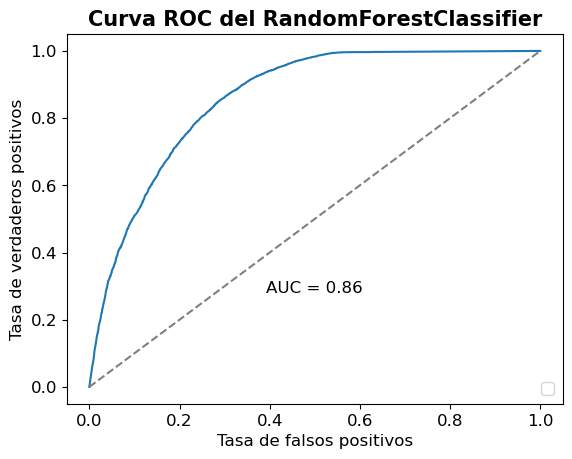

In [81]:
#Roc curve de las clasificaciones
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
# Get the predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]


from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_display.ax_.set_title(f'Curva ROC del {model.__class__.__name__}', fontsize=15, fontweight='bold')
roc_display.ax_.set_xlabel('Tasa de falsos positivos')
roc_display.ax_.set_ylabel('Tasa de verdaderos positivos')
#Diagonal
roc_display.ax_.plot([0, 1], [0, 1], color='grey', linestyle='--')
#Añadir AUC
roc_display.ax_.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}', size=12, ha="center", transform=roc_display.ax_.transAxes)



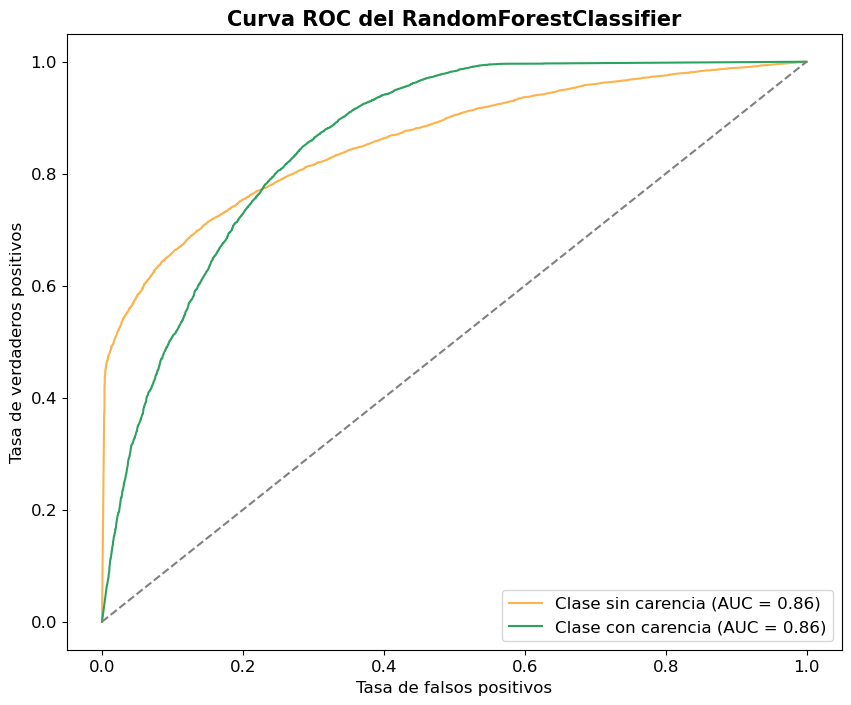

In [82]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'model' is your trained classification model and 'X_test', 'y_test' are your test data and labels

# Get the predicted probabilities
y_pred_proba1 = model.predict_proba(X_test)[:, 0]
y_pred_proba2 = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba1, pos_label=model.classes_[0])
fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba2, pos_label=model.classes_[1])

# Calculate AUC for each class
auc1 = roc_auc_score(y_test == model.classes_[0], y_pred_proba1)
auc2 = roc_auc_score(y_test == model.classes_[1], y_pred_proba2)

# Create a plot
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label=f'Clase sin carencia (AUC = {auc1:.2f})', color='#feb24c')  # ROC curve for class 1
plt.plot(fpr2, tpr2, label=f'Clase con carencia (AUC = {auc2:.2f})', color='#2ca25f')   # ROC curve for class 2
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')                              # Diagonal line

# Customize the plot
plt.title(f'Curva ROC del {model.__class__.__name__}', fontsize=15, fontweight='bold')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend(loc='best')

# Show the plot
plt.show()


Text(0.5, 0.3, 'AUC = 0.86')

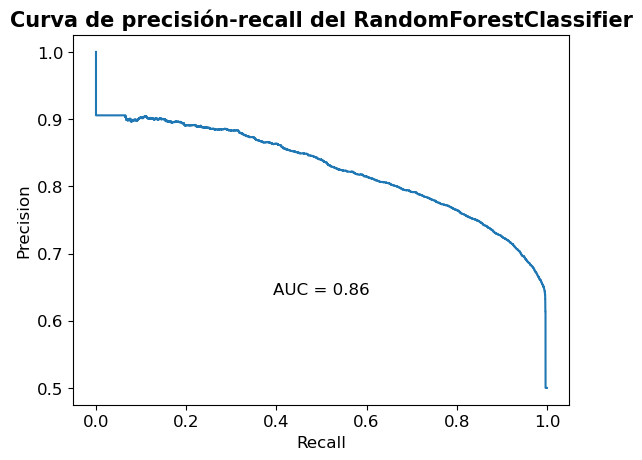

In [83]:
#Hacer la curva de precision-recall
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Get the predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=model.classes_[1])

# Plot the precision-recall curve
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
pr_display.ax_.set_title(f'Curva de precisión-recall del {model.__class__.__name__}', fontsize=15, fontweight='bold')
pr_display.ax_.set_xlabel('Recall')
pr_display.ax_.set_ylabel('Precision')
#Añadir AUC
pr_display.ax_.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}', size=12, ha="center", transform=pr_display.ax_.transAxes)



In [84]:
# Make predictions on the non-NaN subset of features
valid_indices = features_df.index  # indices of non-NaN records in features_df
y_pred_full = model.predict(features_df.loc[valid_indices, 'mean_band4'].values.reshape(-1, 1))
# Add the predictions to the corresponding records in joined_gdf
predrf=joined_gdf.copy()
predrf.loc[valid_indices, 'predictions'] = y_pred_full
predrf = predrf.loc[valid_indices]
#Eliminar columna de rezago_c
predrf=predrf.drop(columns=['rezago_c'])
#crs a wgs84
predrf=predrf.to_crs(epsg=4326)

C:\Users\claud\miniconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [85]:
predrf

,index,geometry,index_right,cvegeo,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,ambito,...,p_viv_ptierra,p_viv_hacina,p_viv_sagua,p_viv_drena,p_viv_energia,vialidad_sinrec,rasgos_mza,ind_rez,slum_severity_index,predictions
53083,53083,"POLYGON ((-99.67750 18.75631, -99.67747 18.758...",68441.0,1204900010042011,12,049,0001,0042,011,Urbana,...,0.0,0.0,0.0,0.0,0.0,50.000000,0.00,3.424034e-01,0.071429,con carencia
53084,53083,"POLYGON ((-99.67750 18.75631, -99.67747 18.758...",68549.0,1204900010042013,12,049,0001,0042,013,Urbana,...,0.0,0.0,0.0,0.0,0.0,80.000000,6.25,5.478454e-01,0.114286,con carencia
53085,53084,"POLYGON ((-99.67550 18.75628, -99.67547 18.758...",68441.0,1204900010042011,12,049,0001,0042,011,Urbana,...,0.0,0.0,0.0,0.0,0.0,50.000000,0.00,3.424034e-01,0.071429,con carencia
53086,53084,"POLYGON ((-99.67550 18.75628, -99.67547 18.758...",68549.0,1204900010042013,12,049,0001,0042,013,Urbana,...,0.0,0.0,0.0,0.0,0.0,80.000000,6.25,5.478454e-01,0.114286,con carencia
53087,53084,"POLYGON ((-99.67550 18.75628, -99.67547 18.758...",68548.0,1204900010042012,12,049,0001,0042,012,Urbana,...,0.0,0.0,0.0,0.0,0.0,86.666667,6.25,5.934992e-01,0.123810,con carencia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630280,3554746,"POLYGON ((-98.51358 16.40922, -98.51353 16.411...",37271.0,120230026039A025,12,023,0026,039A,025,Urbana,...,0.0,0.0,0.0,0.0,0.0,66.666667,25.00,4.565378e-01,0.095238,sin carencia
3630281,3554746,"POLYGON ((-98.51358 16.40922, -98.51353 16.411...",38018.0,120230026039A016,12,023,0026,039A,016,Urbana,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,2.978671e-13,0.000000,sin carencia
3630282,3554747,"POLYGON ((-98.51162 16.40917, -98.51157 16.411...",37271.0,120230026039A025,12,023,0026,039A,025,Urbana,...,0.0,0.0,0.0,0.0,0.0,66.666667,25.00,4.565378e-01,0.095238,con carencia
3633138,3557603,"POLYGON ((-98.51559 16.40736, -98.51554 16.409...",38061.0,120230026039A053,12,023,0026,039A,053,Urbana,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,2.978671e-13,0.000000,sin carencia


In [86]:
#Hacer el mapa de predicciones y observados

import folium

etiqueta_color = {
    'sin carencia': '#ffffb2',
    
    'con carencia': '#bd0026'
}


# Create the Folium map centered on the given location
m = folium.Map(location=[17.6018995, -100.0958137], zoom_start=9,control_scale=True, tiles=None)

# Add the Google Satellite tile layer
folium.TileLayer(
    tiles='http://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}',
    attr="@claudiodanielpc con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020",
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# Function to get the color based on 'klass'
def get_color(feature):
    try:
        klass = feature['properties']['predictions']
    except:
        klass = feature['properties']['rezago_c']
    return etiqueta_color.get(klass, '#000000')

#Grupo cuadricula
cuadricula = folium.FeatureGroup(name='Cuadricula')
# Add GeoJSON to the map with style and tooltip
folium.GeoJson(
    base_mapa.to_json(),
    style_function=lambda feature: {
        'fillColor': get_color(feature),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['rezago_c'],
        aliases=['Etiqueta:'],
        localize=False  # Non-localizable content
    )
).add_to(cuadricula)

#Añadir al mapa
cuadricula.add_to(m)


#Agregar la capa de predicciones
predicciones = folium.FeatureGroup(name='Predicciones')
# Add GeoJSON to the map with style and tooltip
folium.GeoJson(
    predrf.to_json(),
    style_function=lambda feature: {
        'fillColor': get_color(feature),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['predictions'],
        aliases=['Etiqueta:'],
        localize=False  # Non-localizable content
    )
).add_to(predicciones)

#Añadir al mapa
predicciones.add_to(m)

# Define the HTML template for the legend
template = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 220px; height: 170px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.8; padding: 5px;">
    &nbsp; <b>Carencias de vivienda</b> <br>
    &nbsp; Sin carencia &nbsp; <i style="background: #ffffb2; width: 20px; height: 10px; display: inline-block;"></i><br>   
    &nbsp; Con carencia &nbsp; <i style="background: #bd0026; width: 20px; height: 10px; display: inline-block;"></i><br>
</div>
{% endmacro %}
"""


# Create a MacroElement which will be added to the map
macro = MacroElement()
macro._template = Template(template)

# Add the legend to the map
m.get_root().add_child(macro)

folium.LayerControl().add_to(m)
#Salvar mapa
m.save('mapa_rezago_cuadricula_predicciones.html')

In [87]:
os.getcwd()


'C:\\users\\claud\\Documents\\GitHub\\proyecto_infotec'

In [88]:
#Salvar solo la banda 4 como tif
with rasterio.open(image_path) as src:
    # Read the entire image
    subset = src.read(4)  # Reading band 4
    bounds = src.bounds  # Get the bounds of the entire image
    transform = src.transform  # Get the affine transform for the image
    #Guardar como tif
    with rasterio.open('banda4.tif', 'w', driver='GTiff',
                       height=subset.shape[0], width=subset.shape[1],
                       count=1, dtype=subset.dtype,
                       crs=src.crs, transform=src.transform) as dst:
        dst.write(subset, 1)

In [89]:
#Salvar predrf como shapefile
predrf.to_file("datos/predrf.shp")

C:\Users\claud\AppData\Local\Temp\ipykernel_46984\1850559763.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  predrf.to_file("datos/predrf.shp")


C:\Users\claud\miniconda3\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Text(-1, -0.1, 'Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020.')

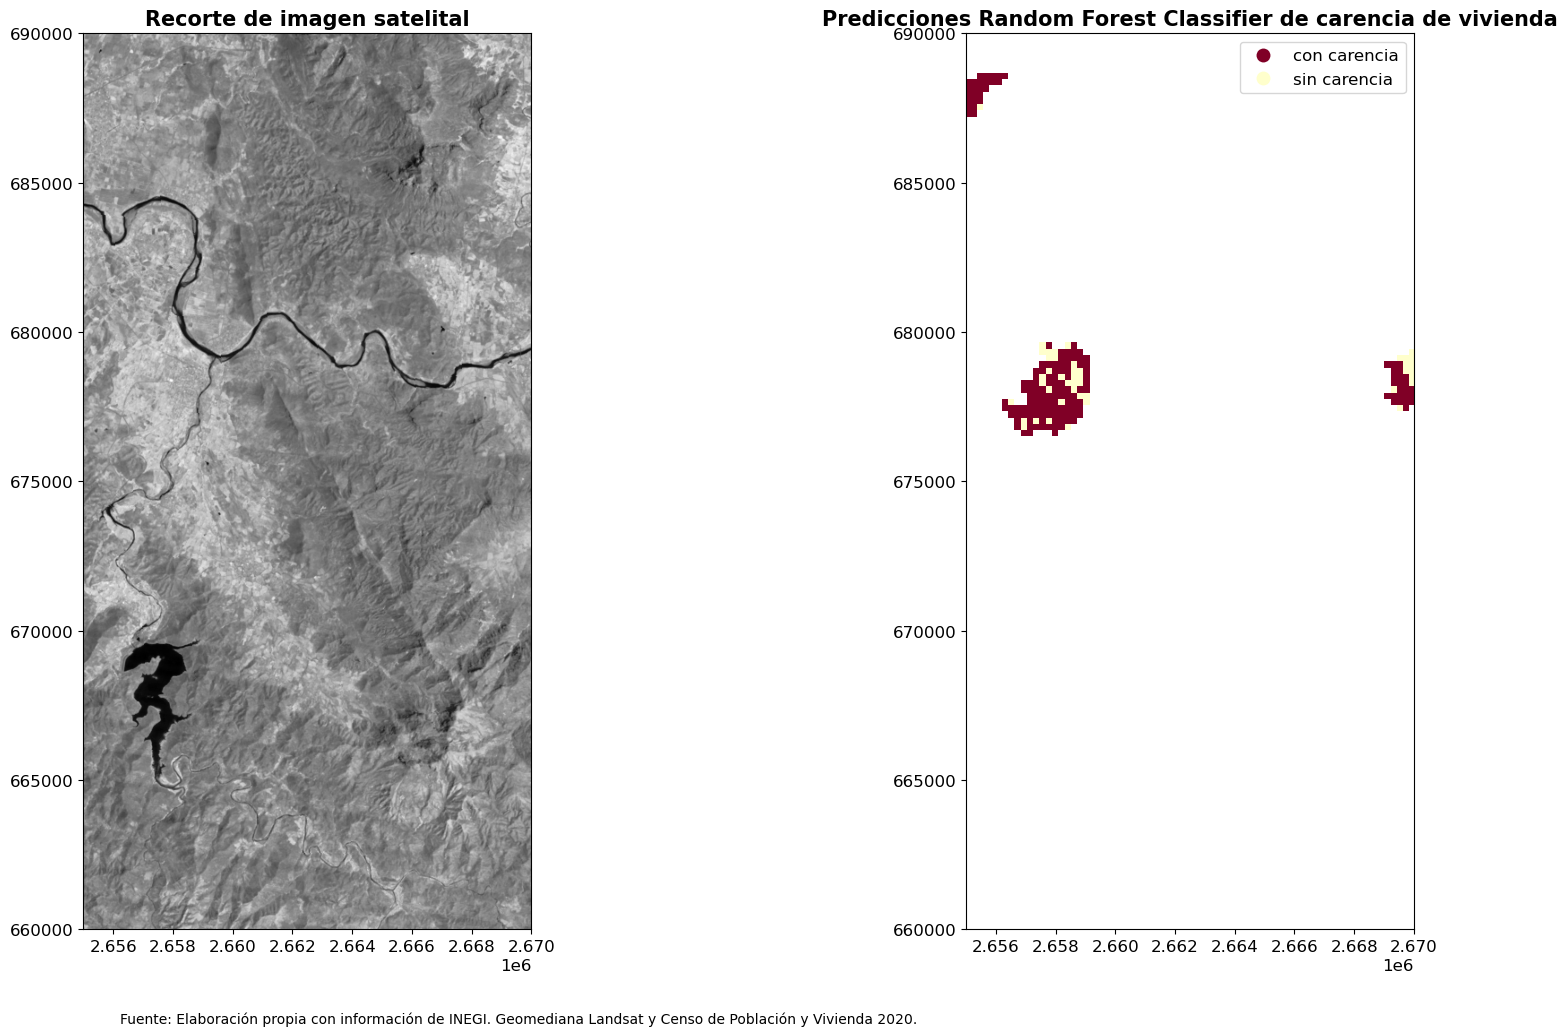

In [90]:
# Change these values to your desired coordinates
x_min, y_min, x_max, y_max = 8500, 2000, 9000, 3000

# Create a dictionary to represent the crop window
crop_window = {
    "col_off": x_min,
    "row_off": y_min,
    "width": x_max - x_min,
    "height": y_max - y_min,
}

# Define the window for the desired range
window = rasterio.windows.Window(
    col_off=crop_window["col_off"],
    row_off=crop_window["row_off"],
    width=crop_window["width"],
    height=crop_window["height"],
)

# Leer la imagen con el recorte
with rasterio.open(image_path) as src:
    subset = src.read(4, window=window)  # Reading band 4
    # Get the bounds of the window
    bounds = src.window_bounds(window)
    transform = src.window_transform(window)
    


# Assuming 'predrf' is a GeoDataFrame that's already been loaded
# Use this geometry to subset your GeoDataFrame
subset_predrf = predrf.copy()
#Reproyectar a la crs de la imagen
subset_predrf=subset_predrf.to_crs(src.crs)
subset_grid=grid_gdf.copy()
subset_grid=subset_grid.to_crs(src.crs)


# Subset the GeoDataFrame to the subset bounds
bounds_geom = box(*bounds)
subset_predrf = subset_predrf[subset_predrf.geometry.intersects(bounds_geom)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Plot the satellite image in the first facet
show(subset, ax=ax1, cmap='Greys_r', transform=transform)
ax1.set_title('Recorte de imagen satelital', fontsize=15, fontweight='bold')
# Get the x and y limits of the satellite image plot
xlim_image, ylim_image = ax1.get_xlim(), ax1.get_ylim()
# Plot the prediction in the second facet
subset_predrf.plot(ax=ax2,
                   column='predictions',
                   categorical=True,
                   cmap="YlOrRd_r",
                   legend=True)
ax2.set_xlim(xlim_image)
ax2.set_ylim(ylim_image)
ax2.set_title('Predicciones Random Forest Classifier de carencia de vivienda', fontsize=15, fontweight='bold')

plt.tight_layout() 

#Fuente
plt.text(-1, -0.1, 'Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020.', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)


C:\Users\claud\miniconda3\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Text(-1, -0.2, 'Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020.')

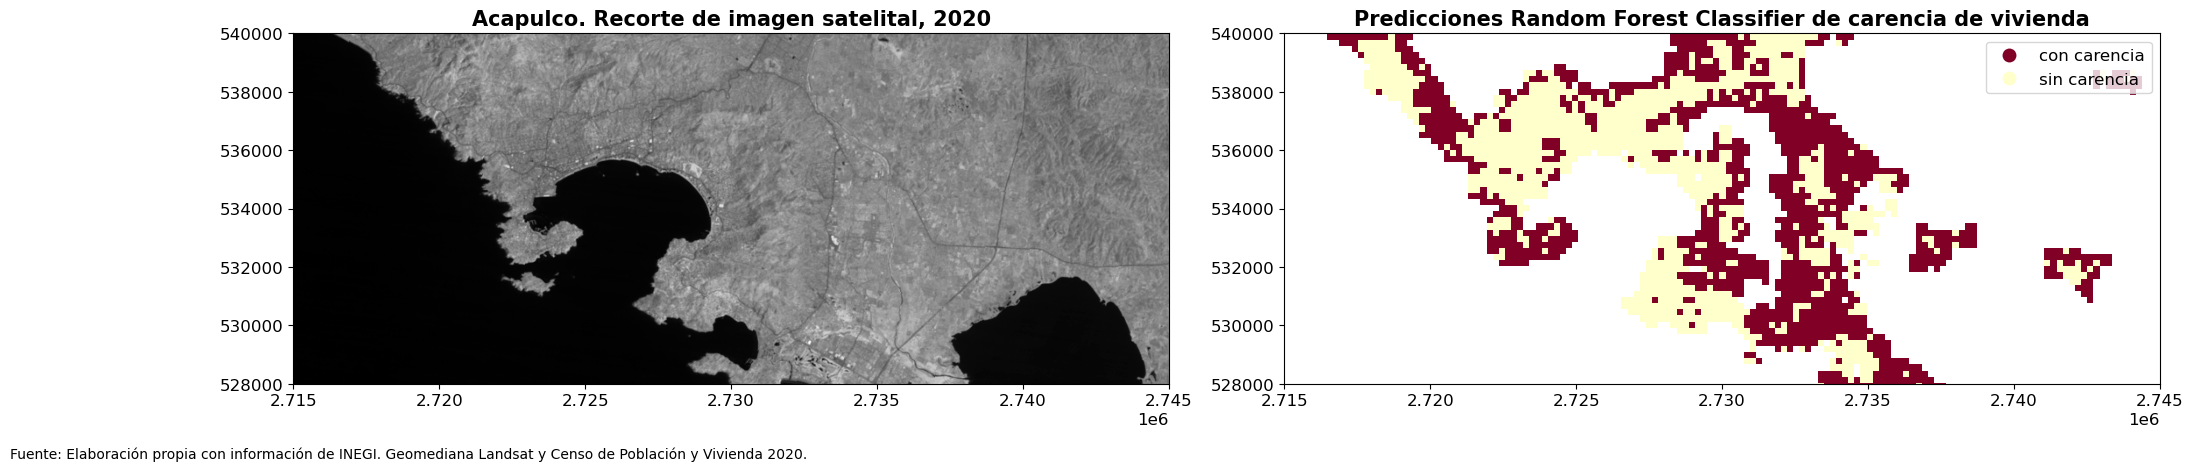

In [91]:
# Change these values to your desired coordinates
x_min, y_min, x_max, y_max = 10500, 7000, 11500, 7400

# Create a dictionary to represent the crop window
crop_window = {
    "col_off": x_min,
    "row_off": y_min,
    "width": x_max - x_min,
    "height": y_max - y_min,
}

# Define the window for the desired range
window = rasterio.windows.Window(
    col_off=crop_window["col_off"],
    row_off=crop_window["row_off"],
    width=crop_window["width"],
    height=crop_window["height"],
)

# Leer la imagen con el recorte
with rasterio.open(image_path) as src:
    subset = src.read(4, window=window)  # Reading band 4
    # Get the bounds of the window
    bounds = src.window_bounds(window)
    transform = src.window_transform(window)
    


# Assuming 'predrf' is a GeoDataFrame that's already been loaded
# Use this geometry to subset your GeoDataFrame
subset_predrf = predrf.copy()
#Reproyectar a la crs de la imagen
subset_predrf=subset_predrf.to_crs(src.crs)
subset_grid=grid_gdf.copy()
subset_grid=subset_grid.to_crs(src.crs)


# Subset the GeoDataFrame to the subset bounds
bounds_geom = box(*bounds)
subset_predrf = subset_predrf[subset_predrf.geometry.intersects(bounds_geom)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Plot the satellite image in the first facet
show(subset, ax=ax1, cmap='Greys_r', transform=transform)
ax1.set_title('Acapulco. Recorte de imagen satelital, 2020', fontsize=15, fontweight='bold')
# Get the x and y limits of the satellite image plot
xlim_image, ylim_image = ax1.get_xlim(), ax1.get_ylim()
# Plot the prediction in the second facet
subset_predrf.plot(ax=ax2,
                   column='predictions',
                   categorical=True,
                   cmap="YlOrRd_r",
                   legend=True)
ax2.set_xlim(xlim_image)
ax2.set_ylim(ylim_image)
ax2.set_title('Predicciones Random Forest Classifier de carencia de vivienda', fontsize=15, fontweight='bold')

plt.tight_layout() 

#Fuente
plt.text(-1, -0.2, 'Fuente: Elaboración propia con información de INEGI. Geomediana Landsat y Censo de Población y Vivienda 2020.', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)
